<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/></p></center>

<h1><center><font size=6>Introduction to Neural Networks: Bank Churn Prediction</center></font></h1>
<h2><center>Project #7</center></h2>
<h3><center>Craig Drummond</center></h3>

# Context

# Questions to Answer

1. Based on the data provided, will a customer "churn" or leave the bank?


# Executive Summary of Analysis

## Conclusions
1. After analyzing 9 different models the best model allows us to predict with 83% accuacy if a customer is likely to "churn" (leave the bank).

2. The following types of customers were identified as higher risk for churning
*   Customers with more than 2 products
*   Customers with only 1 product
*   Customers with lower credit scores
*   Older customers
*   Women
*   Customers from Germany
*   Customers who are inactive



## Recommendations
- Creating an incentive program to get inactive accounts to re-engage with the bank

- Identify customers with more than 2 products and offer a product that consolidates that down to only one or two products max

- A marketing campaign focused on women and the benefits that women can get using the banks products

- A marketing campaign focues on people 55 years and older.  Offering lower rates or other incentives to keep them as a customer

- A marketing campaign in Germany to incentivize customers to stay with the bank

- Offer customers with lower credit scores free training \ advice on how they can improve their credit score.

---------------------------------------------------------------------------

In [151]:
# Import the time library so that the amount of time this notebook takes to run can be processed
import time

begin_total = time.time()


# Install Missing Libraries

In [152]:
# Colab seems to lose certain libraries when the runtime expires.  These two libraries in particular
# need to be verified on each run of the notebook as the notebook will fail without them 

!pip3 install keras-tuner
!pip3 install dask-ml 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Connect to Google Colab

In [153]:
# Connecting to Google Colab requires a manual intervention. That makes running the notebook end to end impossible.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [154]:
# Import the necessary other libraries and setting certain settings for this notebook to run to compltion

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# primary data manipulation libraries
import pandas as pd
import numpy as np

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

# sklearn libaries
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.pipeline import Pipeline


# tensorflow & keras libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers

# from tensorflow import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# dask libraries
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

# SMOTE libraries
from imblearn.over_sampling import SMOTE

# remove number of displayed columns limit
pd.set_option("display.max_columns", None)

# set limit on the number of rows to display
pd.set_option("display.max_rows", 200)

# Custom Functions Used in this Notebook

## histogram_boxplot

In [155]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

## Labeled_barplot

In [156]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, v_ticks=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
        
    if v_ticks is True:
        plt.xticks(rotation=90, fontsize=15)

    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

## Distribution Plot WRT Target

In [157]:
def distribution_plot_wrt_target(data, predictor, target):
    """
    distribution of data with regards to the target variable

    data: dataframe
    predictor: the independent variable
    target: the target variable
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

## Stacked Barplot

In [158]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

## Make Confusion Matrix

In [159]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a graphic of an sklearn Confusion Matrix (cm) using a Seaborn heatmap visualization.
    Arguments

    Copied from the notebooks used in the classroom material
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
  
    if title:
        plt.title(title)

## Visualize Outliers

In [160]:
# funciton to visualize outliers for numeric values
def visualize_outliers(df, num_cols):
    """
      Visualize Outliers in all of the number based columns in a dataframe

      df: data frame
      num_cols: list of numberic columns
    """
    
    plt.figure(figsize=(20,15))
    
    for i, variable in enumerate(num_cols):
        plt.subplot(2, 4, i + 1)
        plt.boxplot(df[variable], whis=1.5)
        plt.tight_layout()
        plt.title(variable)

    plt.show()

## Create Base Model with Dropout

In [161]:
def create_base_model(lr,batch_size):
    """
      create a base model with a specific learning rate and batch size.
      Several of the models in this notbook use this a starting point.

      lr: Learning Rate used by the optimizer
      batch_size: Passedbut currently not used

      This base model has 
      - 256 input variable and is dependent on X_train 
      being defined.  
      - There are 3 hidden layers (128, 64, and 32). 
      - All of the laters except the output layer use relu for activation.
      - Dropout is used for all but the last hidden layer and the output layer.  
      - The output layer activation is sigmoid.
      - The optimizer is Adam
      - The loss is binart_crossentropy
      - the only metrics defined are accuracy

      Retuns a compiled model
    """
    model = Sequential()
    model.add(Dense(256,activation='relu', input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

## Build Model

In [162]:
def build_model(h):
    """
      builds a model with 8 hidden layers
    """
    model = keras.Sequential()
    for i in range(h.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=h.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            h.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

## Probabilities

In [163]:
def probabilities(model, myX_test, myy_test):
  """
    draws an roc_curve diagram

    model: the model that needs to be diagramed
    myX_test: the X_test used by the model
    myy_test: the y_test used by the model

    Returns the threshold that may be used in later steps of the model

    These commands were repeated over and over in one of the case studies that 
    we reviewed.  I converted this a function to follow DRY guidelines and to 
    reduce the chance that the output would not be consistent
  """
  yhat1 = model.predict(myX_test)
  yhat1 = yhat1[:, 0]
  fpr, tpr, thresholds1 = roc_curve(myy_test, yhat1)
  gmeans1 = np.sqrt(tpr * (1-fpr))
  ix = np.argmax(gmeans1)
  print(f"Best Threshold = {thresholds1[ix]}, G-Measn={gmeans1[ix]:.3f}")
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  return thresholds1[ix]


## Chart Loss

In [164]:
def chart_loss(hist_line1, hist_line2, title):
  """
    Provide a diagram of two history lines

    hist_line1: first line from history of a model
    hist_line2: second line from history of a model
    title: The title that will be added to the diagram

    The legend is hard coded to train and validattion
  """
  plt.plot(hist_line1)
  plt.plot(hist_line2)
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show

## Model Confusion Matrix

In [165]:
def model_cm(my_y_test, my_y_pred):
  """
    Helper function for make_confusion_matrix to follow DRY principles as the
    case study example had the exact same lines of text 7 or 8 times.
  """
  cm=confusion_matrix(my_y_test, my_y_pred)
  cm_labels = ['True Positive', 'False Negative', 'False Positive', 'True Negative']
  cm_categories = ['Staying with Bank', 'Leaving Bank']
  make_confusion_matrix(cm, group_names=cm_labels, categories=cm_categories, cmap='Blues')



---



# Load Data and Preprocessing

In [166]:
project_path = '/content/drive/My Drive/Colab Notebooks/08 - Introduction To Neural Networks/Project7/'
dataset_file = 'Churn.csv'

In [167]:
Data = pd.read_csv(project_path+dataset_file)

In [168]:
# print the shape of the dataset as number of rows and columns
print(f"There are {Data.shape[0]} rows and {Data.shape[1]} columns.")

There are 10000 rows and 14 columns.


In [169]:
# dataset information
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Check for null values in the data

In [170]:
# precentage of null values in the data
round(Data.isnull().sum() / Data.isnull().count() * 100, 2)

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

#### Observations
1. There are no null values in the data

### Check for duplicate values in the data

In [171]:
Data.duplicated().sum()

0

#### Observations:
1. There are no duplicate rows

### Statistics (before any data manipulation)

In [172]:
Data.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


#### Observations
1. RowNumber and CustomerId look to be numberic identifiers and will not benefit the model.  These columns will be dropped
2. The scale for CreditScore, Balance, and EstimatedSalary is very large.  This data will need to be scaled
3. All customers in the data have at least one product but no all customers have a credit card.
4. The maximum number of products a customer has is 4


### Counts for the different target variables

In [173]:
Data["Exited"].value_counts(1)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

### Unique Values

In [174]:
Data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

#### Observations
- Surname is just the last name of the customer.  With 2,932 unique values this could dramatically increase the complexity of the model and I don't think a customers last name could be use to predit if they will leave the bank so this column will be dropped.

### Unique Value Counts

In [175]:
for i in Data.describe(include=["object"]).columns:
  print(f"Unique values in {i} are :")
  print(Data[i].value_counts())
  print("+" * 30)

Unique values in Surname are :
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64
++++++++++++++++++++++++++++++
Unique values in Geography are :
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
++++++++++++++++++++++++++++++
Unique values in Gender are :
Male      5457
Female    4543
Name: Gender, dtype: int64
++++++++++++++++++++++++++++++


#### Observations
- all of the data fomes from only three countries.
- the number of customers from France is more than the other two combined
- the spilt between male and female is about 54.6% to 45.4%

## Pre-Preprocessing

### Remove RowNumber and CustomerId

In [177]:
Data.drop(columns="RowNumber", inplace=True)
Data.drop(columns="CustomerId", inplace=True)
Data.drop(columns="Surname", inplace=True)

In [178]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB




---



# Univariate Analysis

## Histogram Boxplots

### CreditScore

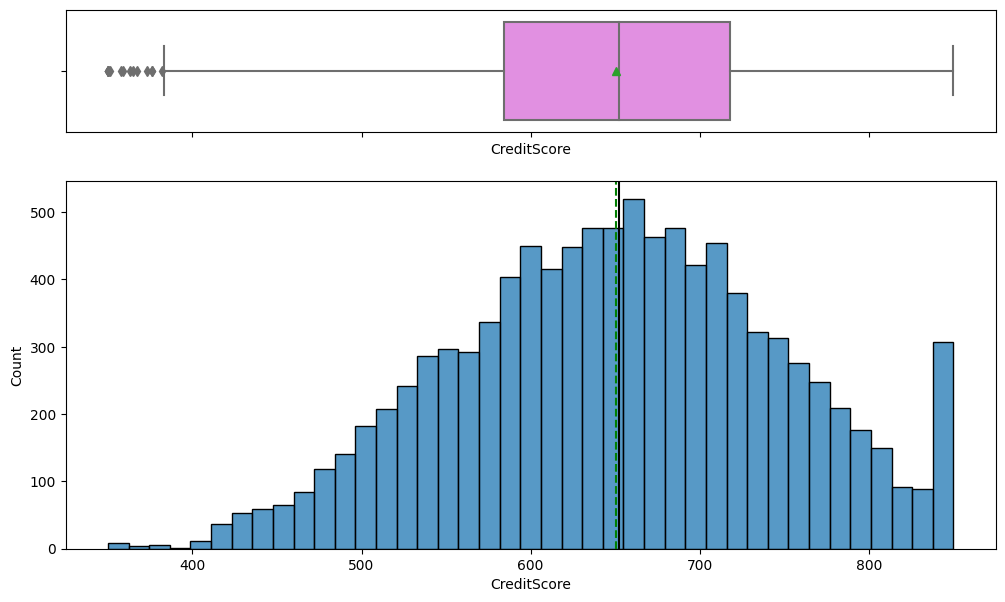

In [179]:
histogram_boxplot(Data, "CreditScore")

#### Observations:
1. CreditScore mean and mode are approximately 648
2. The data is slightly right skewed
3. There as a fair number of outliners on the lower end of the scale

### Age

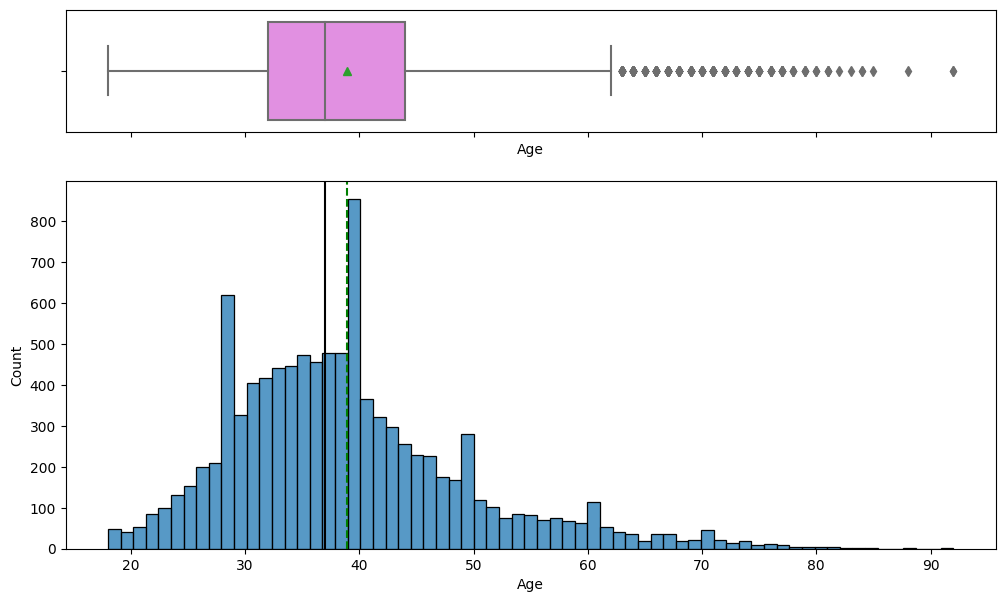

In [180]:
histogram_boxplot(Data, "Age")

#### Observations
1. this data is left skewed
2. there are a fair number of outliers that ar all older
3. the mode is 36 while the mean is 39

### NumOfProducts

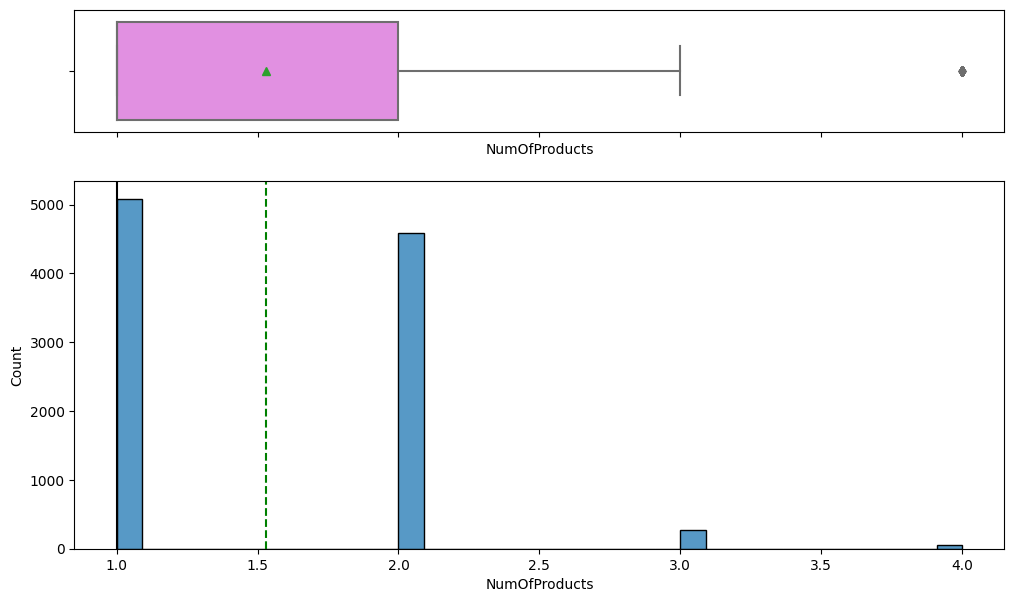

In [181]:
histogram_boxplot(Data, "NumOfProducts")

#### Observations
1. the mean for  numer of products is 1.5, the mode 1
2. the data is left skewed with 96.7% of custoers have either on or 2 products
3. this data does have outliers with a couple of customers having 4 products

## Labeled Barplots

### Number of Products

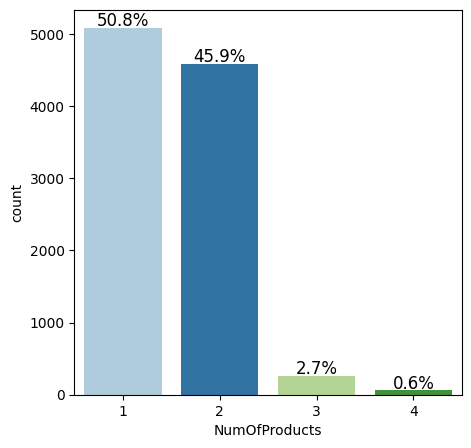

In [182]:
labeled_barplot(Data,"NumOfProducts", True, False)

#### Observations:
1. 50.7% of customers have only one product with the bank
2. A majority of customers have one or two products. Only 3.3% have more than two products
3. only .6% (60) customers have four products

### Tenure

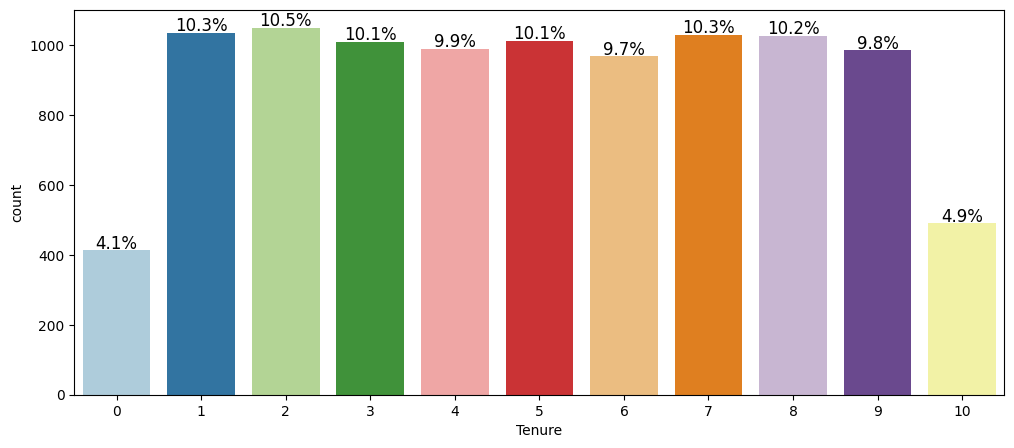

In [183]:
labeled_barplot(Data,"Tenure", True, False)

#### Observations
1. a majority of the customers have been with the back for 2 - 9 years.
2. only 4.1% have been with the bank for 1 year
3. only 4.9% have been with the back for 10 years

### Has Credit Card

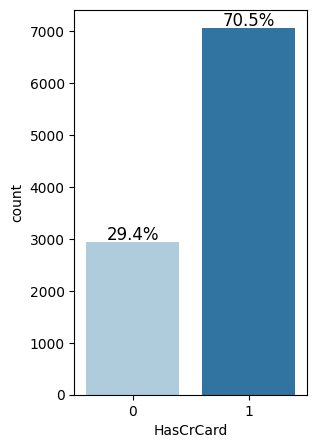

In [184]:
labeled_barplot(Data,"HasCrCard", True, False)

#### Observations:
1. 29.4% of customers do not have a credit card
2. 70.5% of customers have a credit card

### Is Active Member:

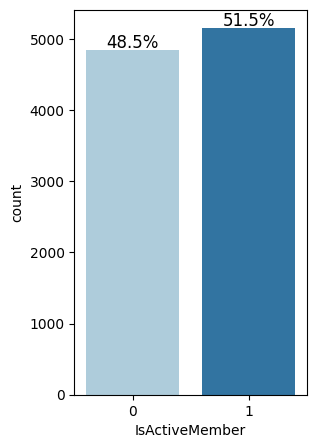

In [185]:
labeled_barplot(Data,"IsActiveMember", True, False) 

#### Observations:
1. 48.5% of customers are still customers but they are not active in using the products they have
2. 51.5% of customers are still active customers



---



## Target Variable Distribution

0    7963
1    2037
Name: Exited, dtype: int64


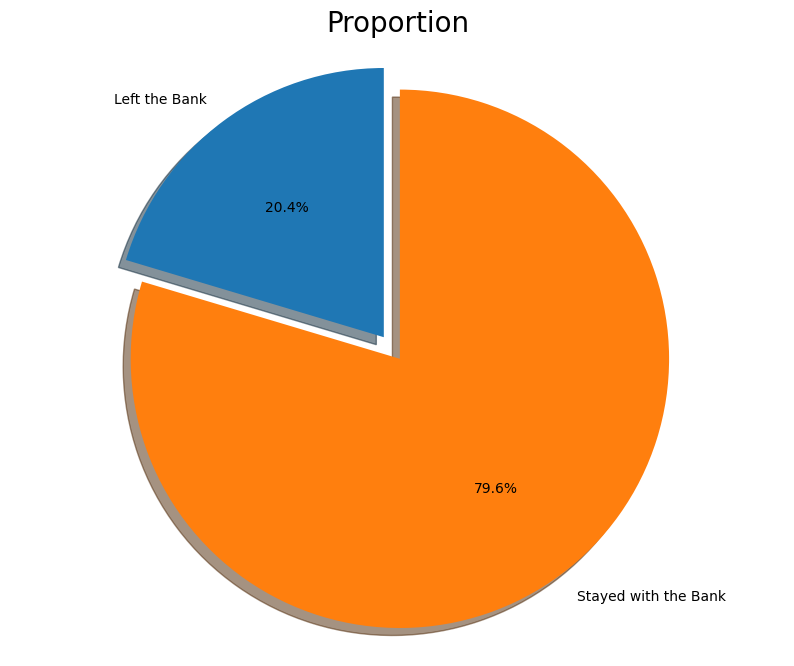

In [186]:
print(Data.Exited.value_counts())
labels = 'Left the Bank', 'Stayed with the Bank'
sizes = [Data.Exited[Data['Exited']==1].count(),Data.Exited[Data['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion", size = 20)
plt.show()

# Bivariate Analysis

## Distribution WRT Exited

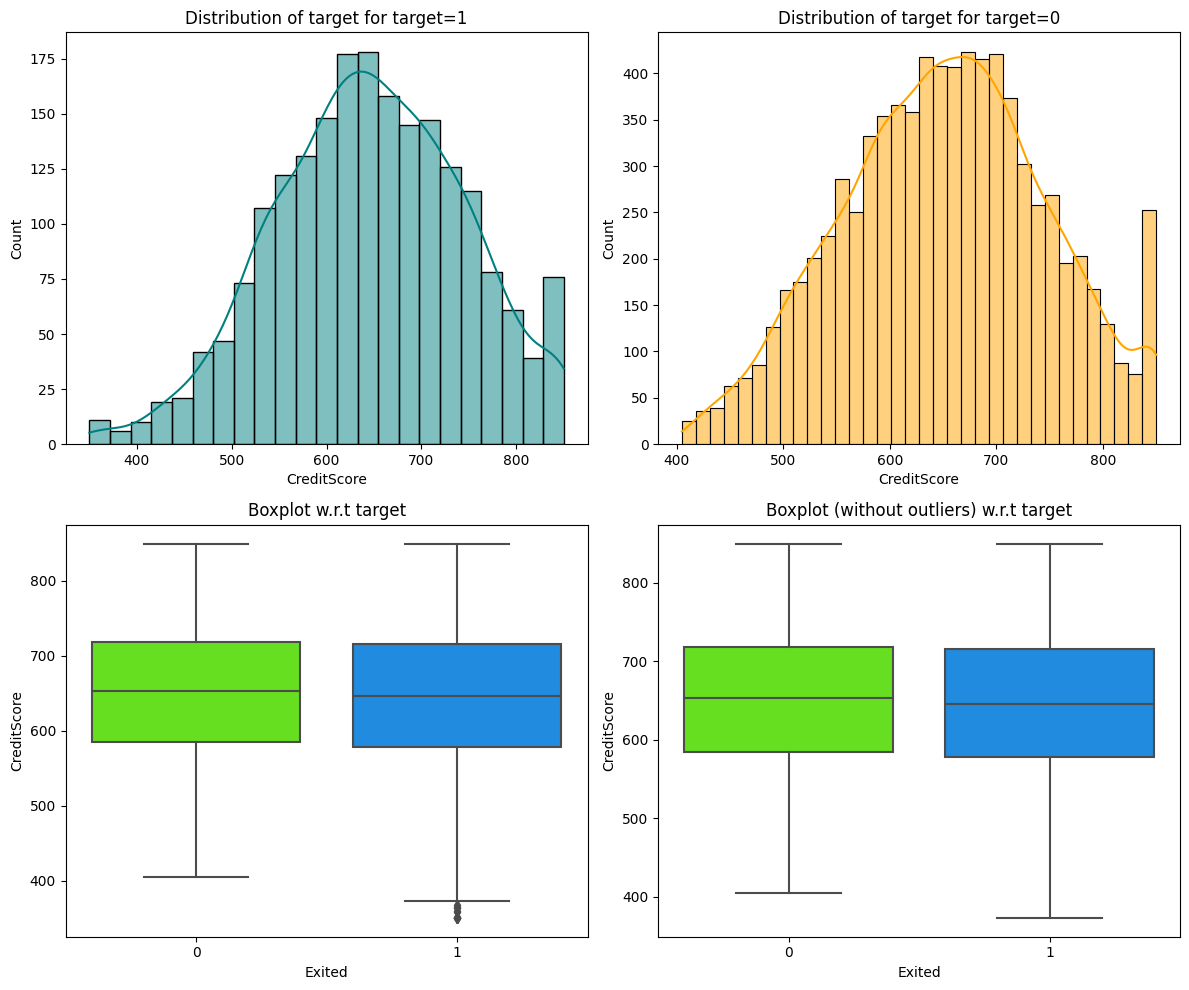

In [187]:
distribution_plot_wrt_target(Data, "CreditScore", "Exited")

#### Observations
1. Customers with the lowest credit scores test to be the customers who exit

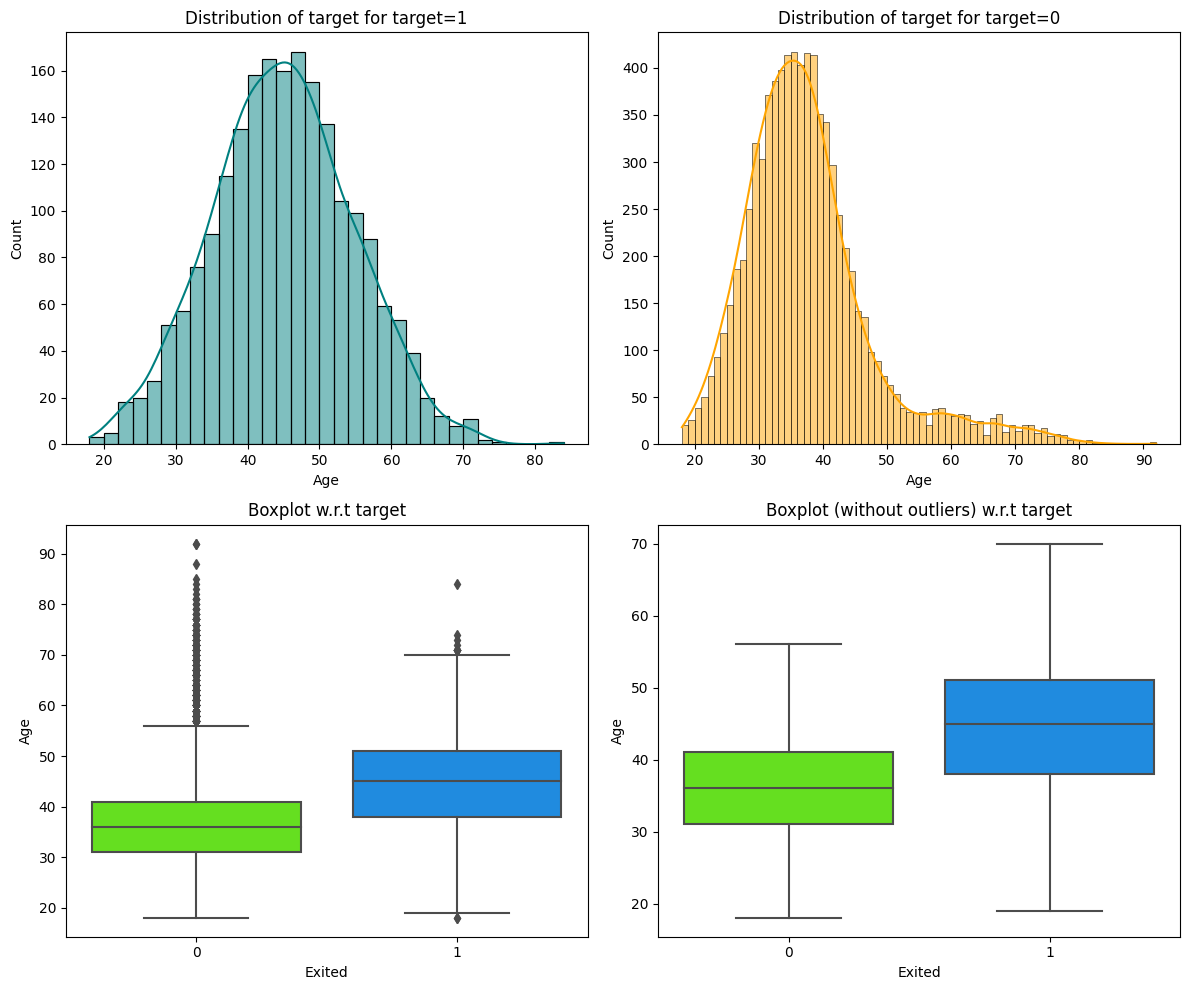

In [188]:
distribution_plot_wrt_target(Data, "Age", "Exited")

#### Observations
1. The older you are the more likely you are to exit.
2. the average age of customers who stayed is 36, the average age of customers who left the back is 45

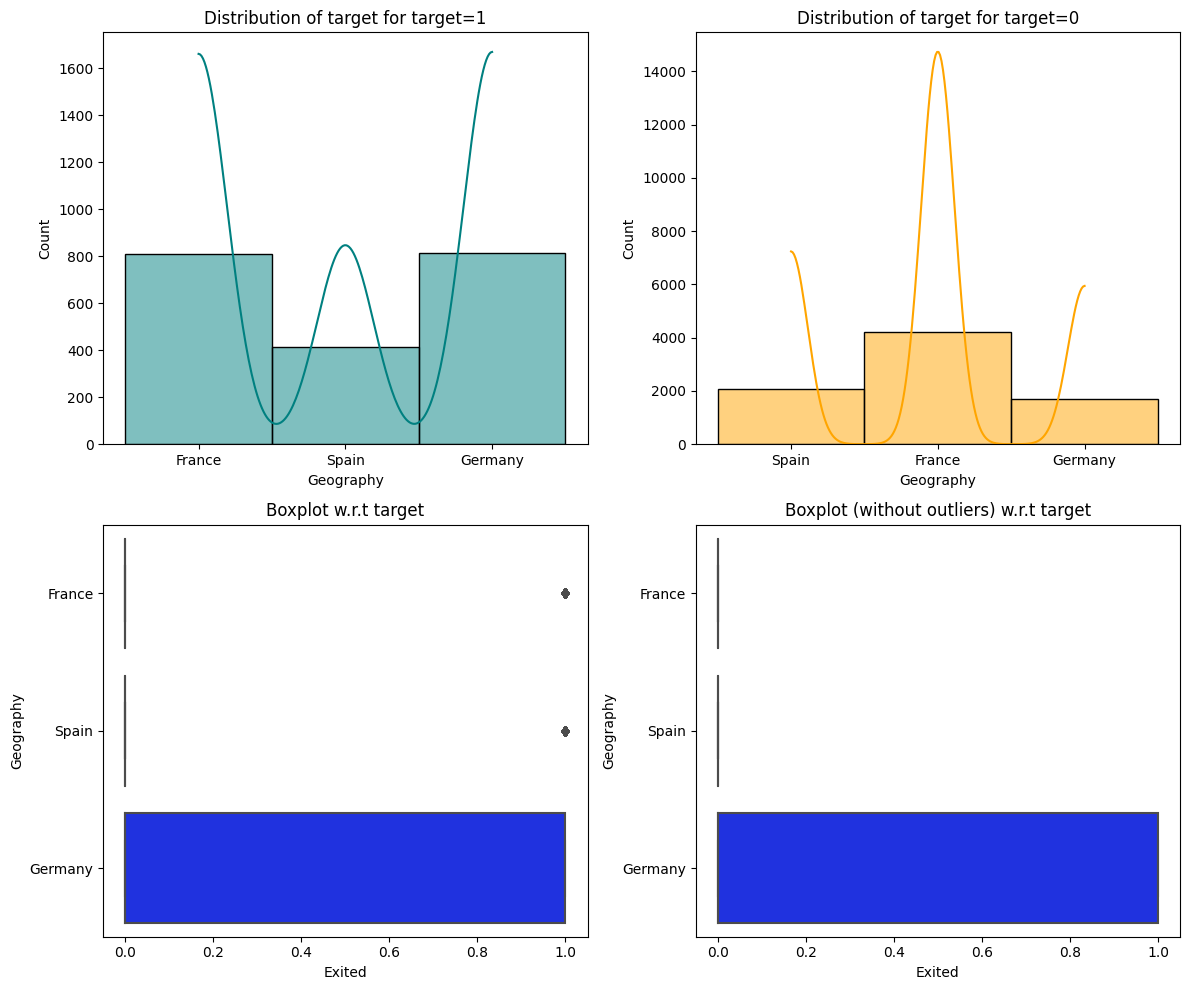

In [189]:
distribution_plot_wrt_target(Data, "Geography", "Exited")

#### Observations
1. More customers from France and Germeny left the bank
2. half as many customers from Spain lef the bank

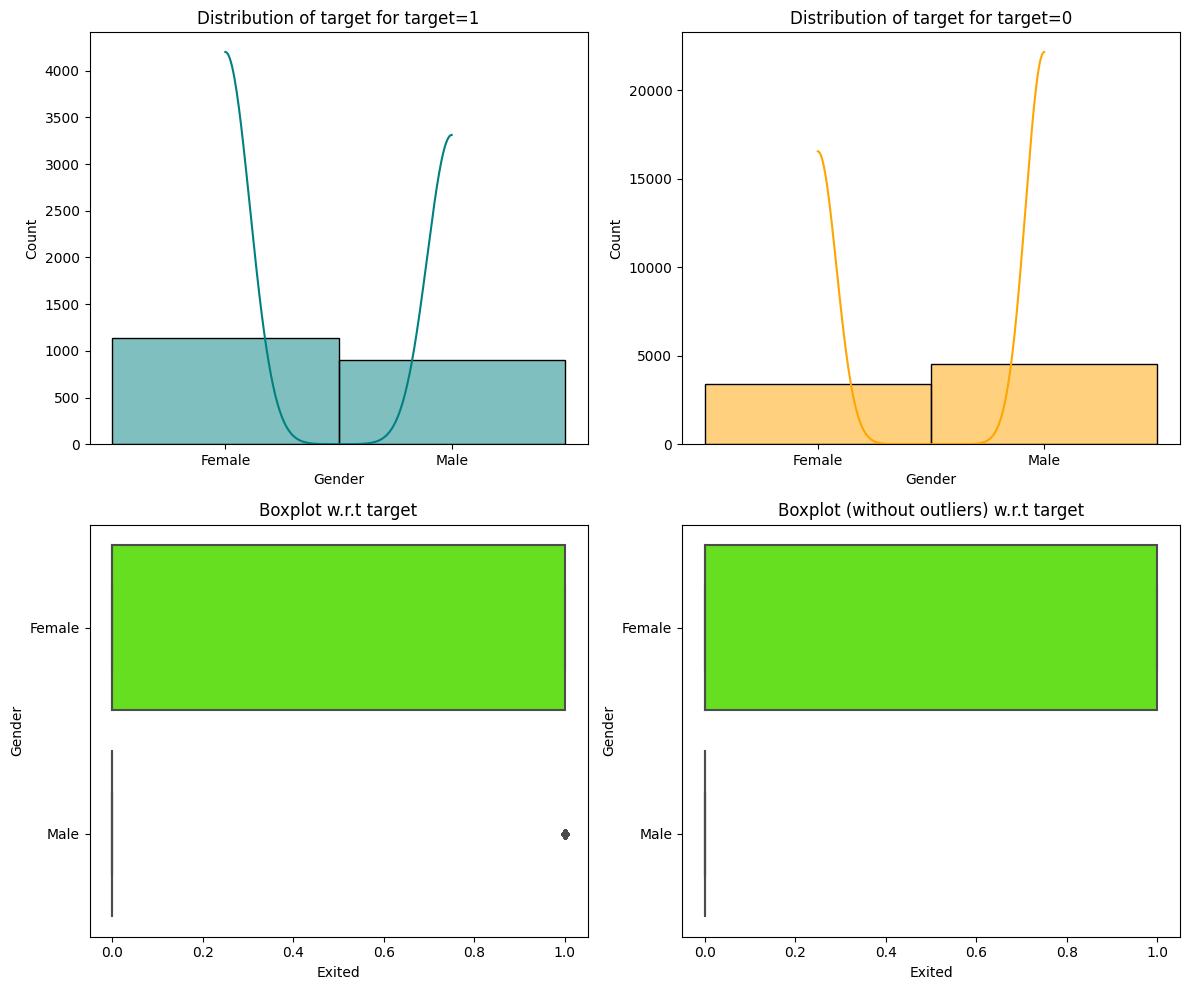

In [190]:
distribution_plot_wrt_target(Data, "Gender", "Exited")

#### Observations
1. slightly more females left the bank than males

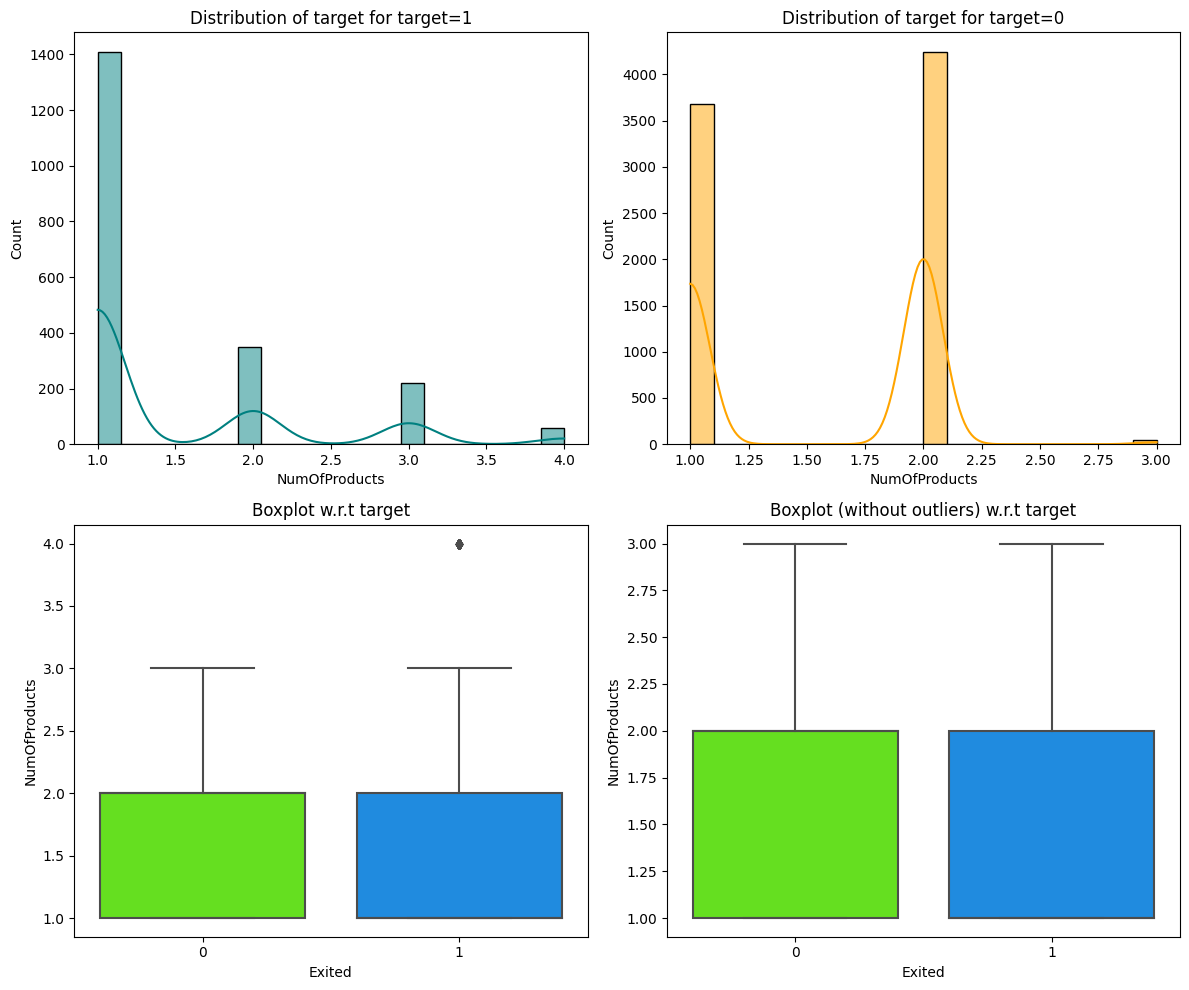

In [191]:
distribution_plot_wrt_target(Data, "NumOfProducts", "Exited")

#### Observations
1. Customers with 2 or more products are less likely to leave the bank

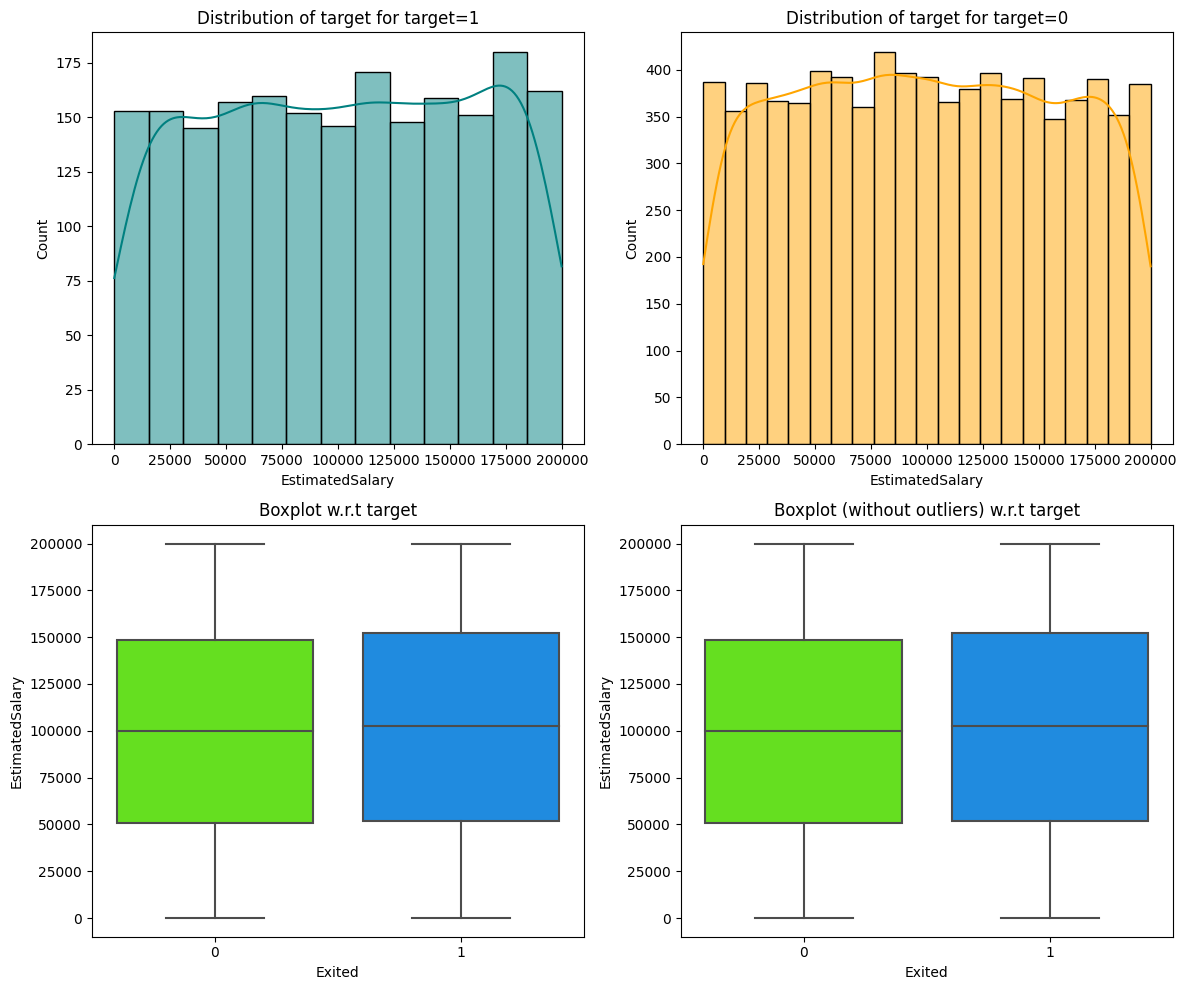

In [192]:
distribution_plot_wrt_target(Data, "EstimatedSalary", "Exited")

#### Observations
1. Salary levels don't seem to have any impact on a customer leaving the bank
the average salare of 100,000 is th same for both customers leaving or staying with the bank

## Stacked Barplot

### Age and Exited

Exited     0     1    All
Age                      
All     7963  2037  10000
46       135    91    226
40       343    89    432
43       209    88    297
45       142    87    229
48        88    80    168
47        98    77    175
42       244    77    321
49        72    75    147
44       184    73    257
39       351    72    423
50        63    71    134
41       297    69    366
51        53    66    119
52        38    64    102
38       414    63    477
37       416    62    478
35       417    57    474
36       403    53    456
54        33    51     84
56        20    50     70
55        34    48     82
33       398    44    442
53        34    40     74
57        37    38     75
34       414    33    447
31       371    33    404
32       386    32    418
60        30    32     62
59        32    30     62
58        38    29     67
29       320    28    348
30       303    24    327
28       250    23    273
62        31    21     52
61        32    21     53
63        22

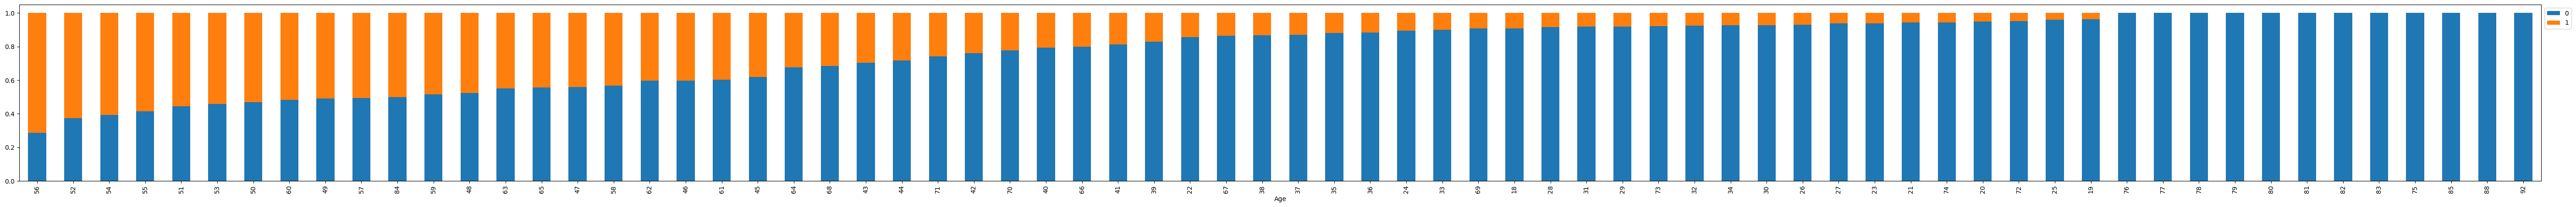

In [194]:
stacked_barplot(Data, "Age", "Exited")

#### Observatons
1. No customers over 75 left the bank
2. More cusomters age 56 left the bank than any other age

### Geography and Exited

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


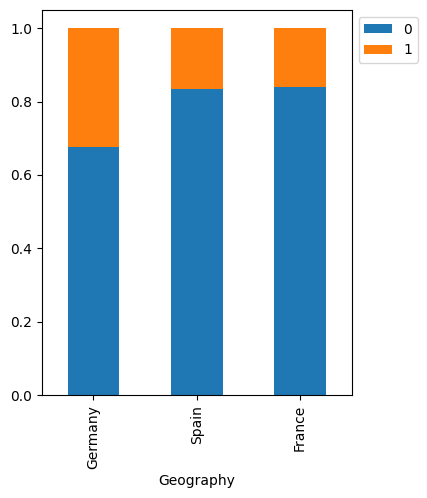

In [195]:
stacked_barplot(Data, "Geography", "Exited")

#### Observations
1. More customer left from Germany that any other geography

### Gender and Exited

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


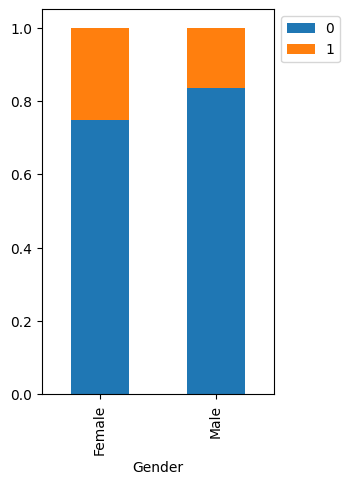

In [196]:
stacked_barplot(Data, "Gender", "Exited")

#### Observations
1. More women than men left the bank

### NumOfProducts and Exited

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


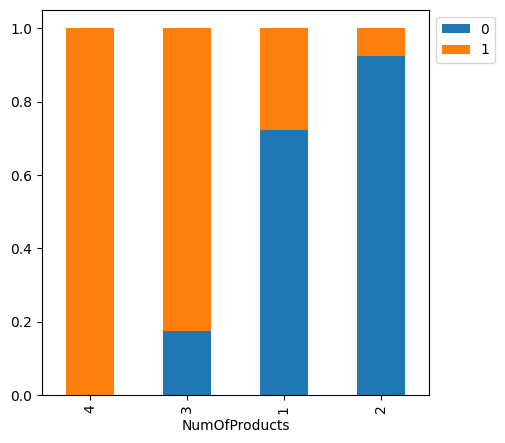

In [197]:
stacked_barplot(Data, "NumOfProducts", "Exited")

#### Observations
1. The optimal number of prodcuts is 2. The least optimal is 4.
2. Nearly all customers that reported as having 4 products left the bank

### HasCrCard and Exited

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


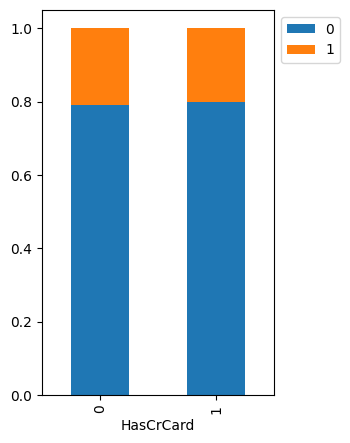

In [198]:
stacked_barplot(Data, "HasCrCard", "Exited")

#### Observations
1. Having a credit card or not doesn't appear to impact whether the customer leaves the bank

### IsActiveMember and Exited

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


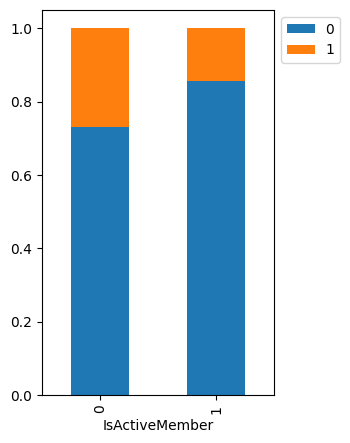

In [199]:
stacked_barplot(Data, "IsActiveMember", "Exited")

#### Observations
1. inactive members are more likely to leave the bank
2. ~15% of active members still leave the bank

## Heatmap

<Axes: >

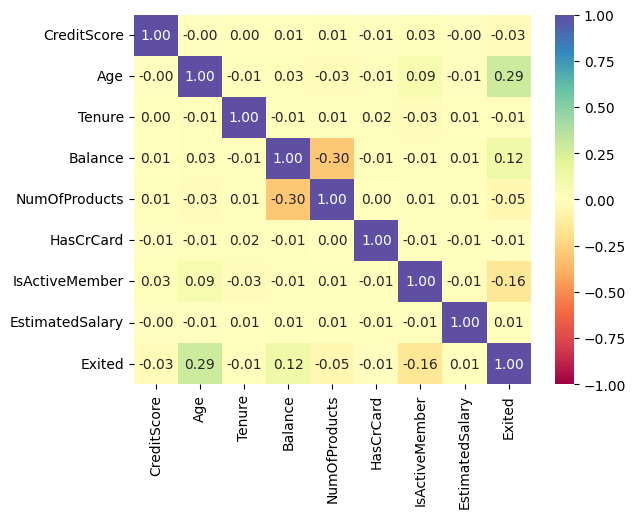

In [200]:
sns.heatmap(Data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")

#### Observations:
1. Age looks to be the only category positively corrlated to exiting at any substantative level
2. Balance and estimated salary are the only other possive correlations


## Outliers Visualization

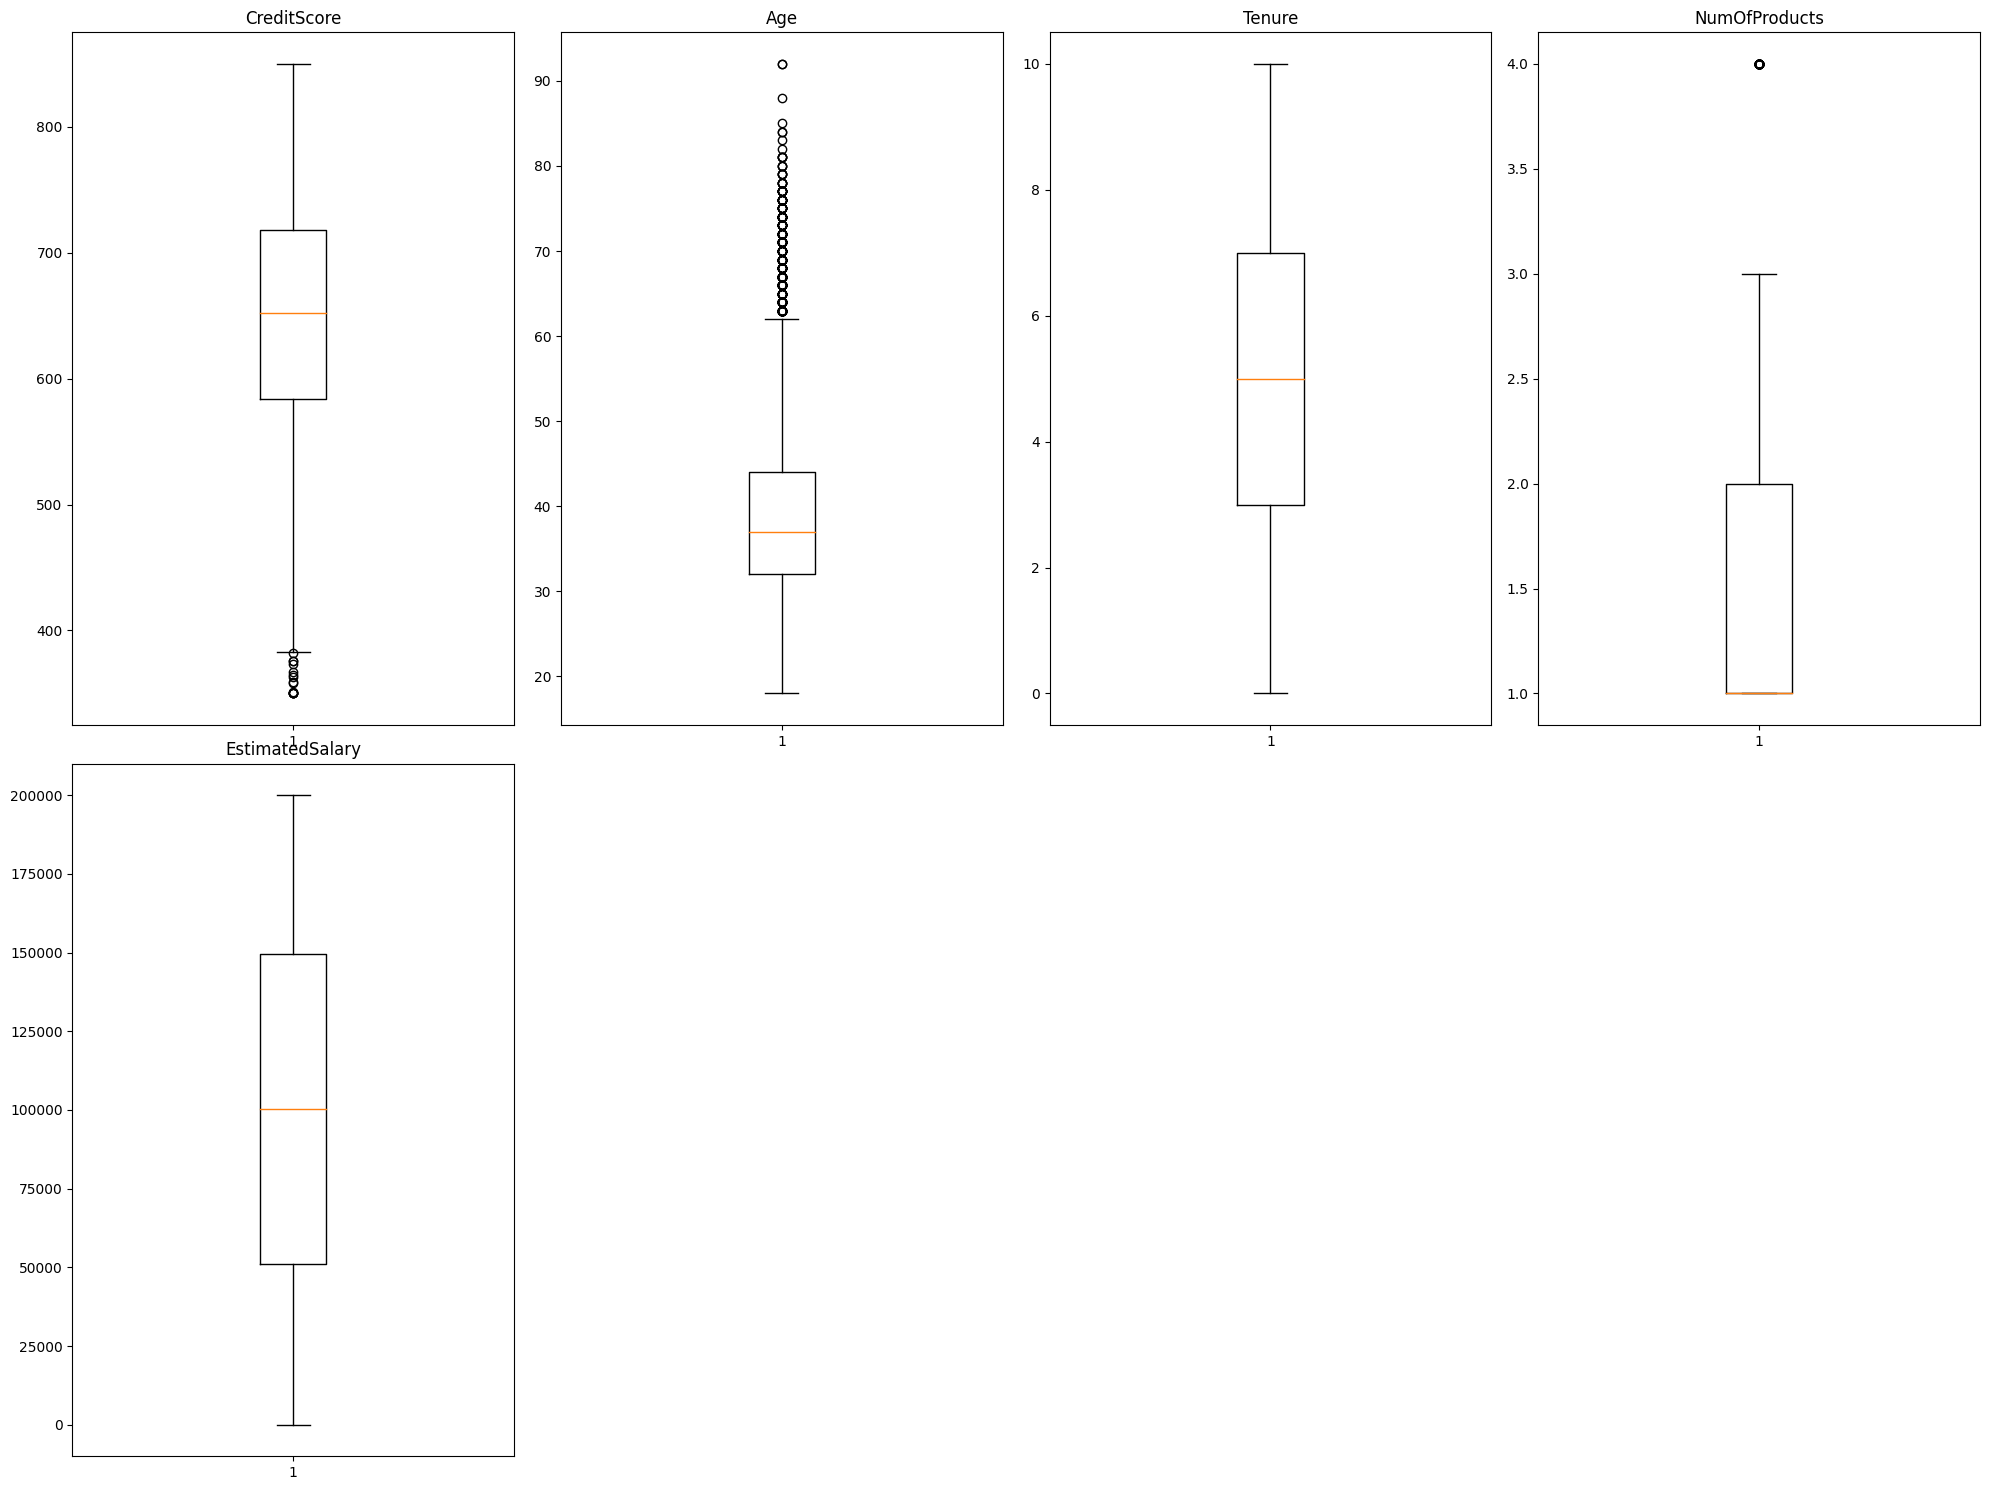

In [201]:
num_cols = ["CreditScore", "Age", "Tenure", "NumOfProducts", "EstimatedSalary"]
visualize_outliers(Data, num_cols)

#### Observations:
1. CreditScore, Age, and NumberOfProdcuts all have some level of outliers

All of these are expected to have outliers and nothing will be done to adjust for these outliers



---



# Final Preparation of Data

## Data Split

In [202]:
X = Data.drop(['Exited'], axis=1)
y = Data[['Exited']]

In [203]:
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


In [204]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify = y)

In [205]:
X_train.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

## Encode the categorical columns

In [206]:
labelencoder_GEO = LabelEncoder()
X_train['Geography'] = labelencoder_GEO.fit_transform(X_train['Geography'])
X_test['Geography'] = labelencoder_GEO.fit_transform(X_test['Geography'])

In [207]:
labelencoder_Gen = LabelEncoder()
X_train['Gender'] = labelencoder_Gen.fit_transform(X_train['Gender'])
X_test['Gender'] = labelencoder_Gen.fit_transform(X_test['Gender'])

## Scale the dsata using MinMaxScaler

In [208]:
# Scale the Data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [209]:
X_test = scaler.transform(X_test)

In [210]:
print(X_train.shape)
print(X_test.shape)
print('+' * 30)
print(y_train.shape)
print(y_test.shape)

(8000, 10)
(2000, 10)
++++++++++++++++++++++++++++++
(8000, 1)
(2000, 1)


# Model building, analysis and comparison



---



## Model 1 With One Hidden Layer, SGB Optimizer

In [211]:
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_dim = 10))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation = 'sigmoid'))
model1.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                704       
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


In [212]:
history1=model1.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1)

Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 0.5515 - accuracy: 0.7714 - val_loss: 0.5145 - val_accuracy: 0.7906
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.5030 - accuracy: 0.7977 - val_loss: 0.5062 - val_accuracy: 0.7906
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4952 - accuracy: 0.7977 - val_loss: 0.5005 - val_accuracy: 0.7906
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4897 - accuracy: 0.7977 - val_loss: 0.4955 - val_accuracy: 0.7906
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4853 - accuracy: 0.7977 - val_loss: 0.4921 - val_accuracy: 0.7906
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4815 - accuracy: 0.7977 - val_loss: 0.4890 - val_accuracy: 0.7906
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7977 - val_loss: 0.4859 - val_accuracy: 0.7906
Epoch 

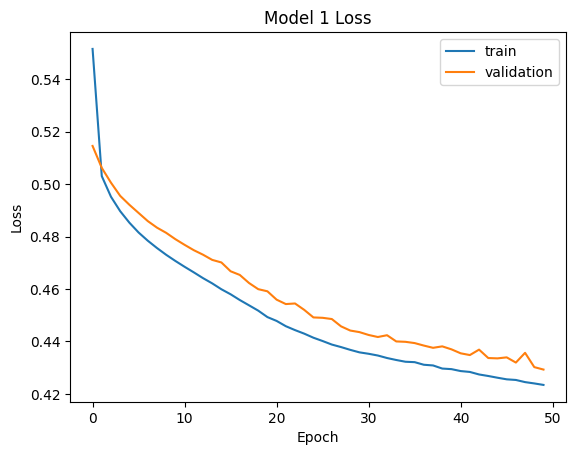

In [213]:
chart_loss(history1.history['loss'], history1.history['val_loss'], 'Model 1 Loss')

In [214]:
m1_y_pred = model1.predict(X_test)
m1_y_pred = (m1_y_pred > 0.5)

63/63 [==============================] - 0s 2ms/step


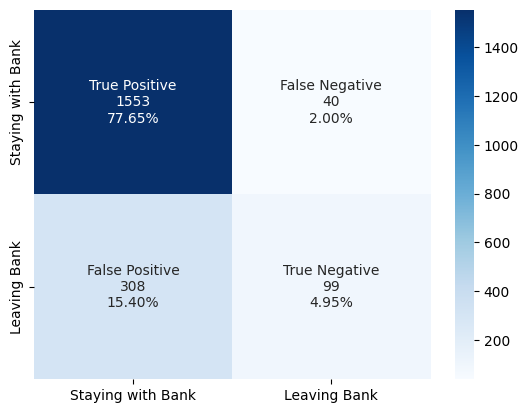

In [215]:
model_cm(y_test, m1_y_pred)

In [216]:
print(f"{metrics.classification_report(y_test, m1_y_pred)}")

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1593
           1       0.71      0.24      0.36       407

    accuracy                           0.83      2000
   macro avg       0.77      0.61      0.63      2000
weighted avg       0.81      0.83      0.79      2000





---



## Model 2 With three hidden laters and he_uniform for kernel_initializer

In [217]:
model2 = Sequential()
model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform', input_dim = X_train.shape[1]))
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               2816      
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 46,081
Trainable params: 46,081
Non-trainable params: 0
_________________________________________________________________


In [218]:
history2 = model2.fit(X_train, y_train, 
                      batch_size=64, 
                      epochs=50, 
                      verbose=2, 
                      validation_split = 0.2)

Epoch 1/50
100/100 - 2s - loss: 0.4678 - accuracy: 0.8012 - val_loss: 0.4443 - val_accuracy: 0.8131 - 2s/epoch - 23ms/step
Epoch 2/50
100/100 - 0s - loss: 0.4146 - accuracy: 0.8263 - val_loss: 0.3855 - val_accuracy: 0.8475 - 490ms/epoch - 5ms/step
Epoch 3/50
100/100 - 0s - loss: 0.3797 - accuracy: 0.8423 - val_loss: 0.3753 - val_accuracy: 0.8487 - 352ms/epoch - 4ms/step
Epoch 4/50
100/100 - 0s - loss: 0.3645 - accuracy: 0.8498 - val_loss: 0.3708 - val_accuracy: 0.8512 - 333ms/epoch - 3ms/step
Epoch 5/50
100/100 - 0s - loss: 0.3553 - accuracy: 0.8539 - val_loss: 0.3805 - val_accuracy: 0.8475 - 372ms/epoch - 4ms/step
Epoch 6/50
100/100 - 0s - loss: 0.3536 - accuracy: 0.8509 - val_loss: 0.3693 - val_accuracy: 0.8537 - 327ms/epoch - 3ms/step
Epoch 7/50
100/100 - 0s - loss: 0.3479 - accuracy: 0.8553 - val_loss: 0.3559 - val_accuracy: 0.8581 - 334ms/epoch - 3ms/step
Epoch 8/50
100/100 - 0s - loss: 0.3443 - accuracy: 0.8539 - val_loss: 0.3595 - val_accuracy: 0.8575 - 364ms/epoch - 4ms/step
Ep

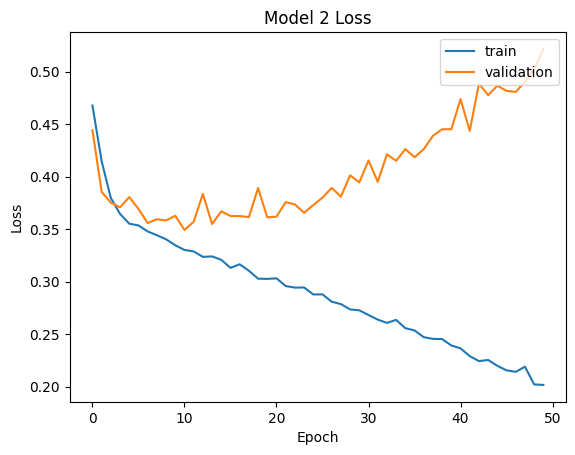

In [219]:
chart_loss(history2.history['loss'], history2.history['val_loss'], "Model 2 Loss")

63/63 [==============================] - 0s 2ms/step
Best Threshold = 0.14090995490550995, G-Measn=0.731


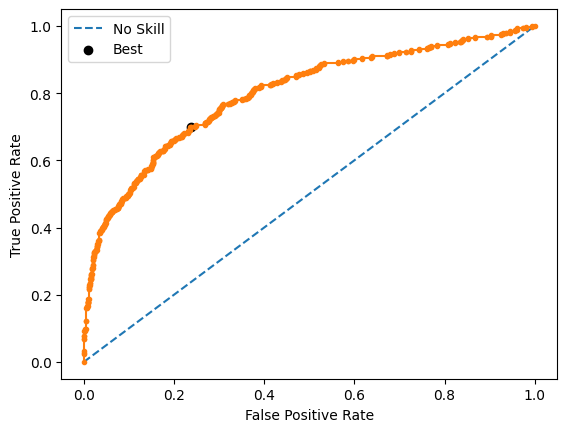

In [220]:
threshold2 = probabilities(model2, X_test, y_test)

In [221]:
# Predicting result using best as threshold
m2_y_pred_best = model2.predict(X_test)
m2_y_pred_best = (m2_y_pred_best > threshold2)

63/63 [==============================] - 0s 2ms/step


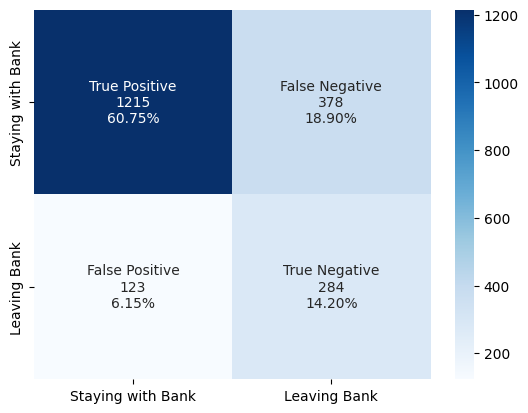

In [222]:
model_cm(y_test, m2_y_pred_best)

In [223]:
print(f"{metrics.classification_report(y_test, m2_y_pred_best)}")

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1593
           1       0.43      0.70      0.53       407

    accuracy                           0.75      2000
   macro avg       0.67      0.73      0.68      2000
weighted avg       0.81      0.75      0.77      2000





---



#### Observations
1. Accuracy dropped to 75%
2. 501 incorrectly categorized customers is worse than the 348 of the Model1



---



## Model 3 Sequential with Batch Normalization

In [224]:
model3 = Sequential()
model3.add(Dense(128, activation='relu', input_dim = X_train.shape[1]))
model3.add(BatchNormalization())
model3.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dense(1, activation = 'sigmoid'))

opt = tf.keras.optimizers.Adam(0.001)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 128)               1408      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 1)                

In [225]:
history3 = model3.fit(X_train, y_train, 
                      batch_size=64, 
                      epochs=50, 
                      verbose=2, 
                      validation_split = 0.2)

Epoch 1/50
100/100 - 3s - loss: 0.5210 - accuracy: 0.7547 - val_loss: 0.5356 - val_accuracy: 0.7906 - 3s/epoch - 30ms/step
Epoch 2/50
100/100 - 0s - loss: 0.3790 - accuracy: 0.8398 - val_loss: 0.4762 - val_accuracy: 0.7950 - 290ms/epoch - 3ms/step
Epoch 3/50
100/100 - 0s - loss: 0.3640 - accuracy: 0.8459 - val_loss: 0.4223 - val_accuracy: 0.8194 - 402ms/epoch - 4ms/step
Epoch 4/50
100/100 - 0s - loss: 0.3526 - accuracy: 0.8491 - val_loss: 0.3864 - val_accuracy: 0.8331 - 388ms/epoch - 4ms/step
Epoch 5/50
100/100 - 0s - loss: 0.3465 - accuracy: 0.8572 - val_loss: 0.3762 - val_accuracy: 0.8388 - 410ms/epoch - 4ms/step
Epoch 6/50
100/100 - 0s - loss: 0.3395 - accuracy: 0.8587 - val_loss: 0.3638 - val_accuracy: 0.8500 - 394ms/epoch - 4ms/step
Epoch 7/50
100/100 - 0s - loss: 0.3332 - accuracy: 0.8609 - val_loss: 0.3660 - val_accuracy: 0.8506 - 390ms/epoch - 4ms/step
Epoch 8/50
100/100 - 0s - loss: 0.3322 - accuracy: 0.8584 - val_loss: 0.3707 - val_accuracy: 0.8525 - 394ms/epoch - 4ms/step
Ep

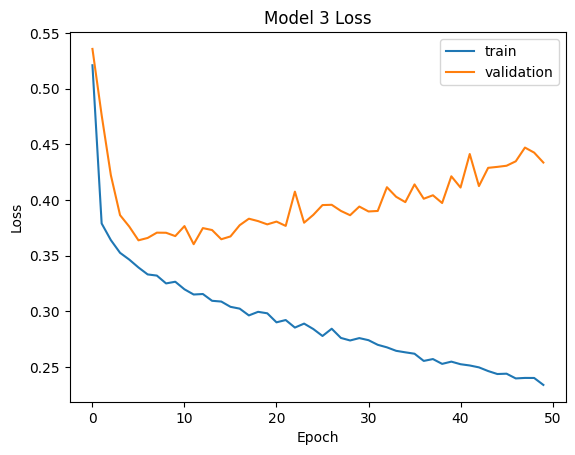

In [226]:
chart_loss(history3.history['loss'], history3.history['val_loss'], 'Model 3 Loss')

#### Obervations
1. Validation Loss went in the wrong direction for this model

63/63 [==============================] - 0s 1ms/step
Best Threshold = 0.15534734725952148, G-Measn=0.749


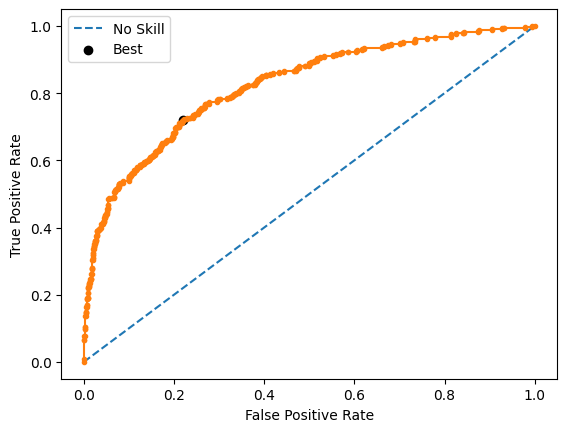

In [227]:
threshold3 = probabilities(model3, X_test, y_test)

In [228]:
# Predicting result using best as threshold
m3_y_pred_best = model3.predict(X_test)
m3_y_pred_best = (m3_y_pred_best > threshold3)

63/63 [==============================] - 0s 1ms/step


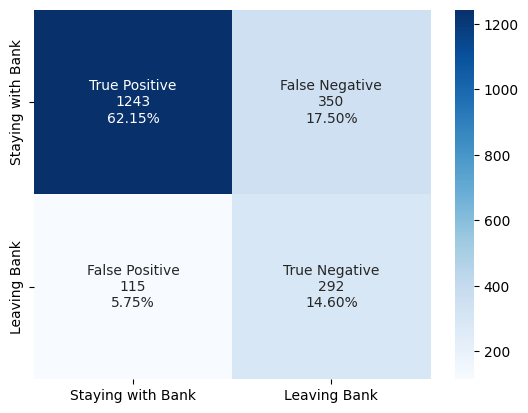

In [229]:
model_cm(y_test, m3_y_pred_best)

In [230]:
print(f"{metrics.classification_report(y_test, m3_y_pred_best)}")

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1593
           1       0.45      0.72      0.56       407

    accuracy                           0.77      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.82      0.77      0.78      2000



#### Observations
1. Accuracy dropped to 77%
2. 465 incorrectly categorized customers is worse than the 348 of the Model1



---



## Model 4 Sequention with Dropout

In [231]:
model4 = Sequential()
model4.add(Dense(256, activation='relu', input_dim = X_train.shape[1]))
model4.add(Dropout(0.2))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(1, activation = 'sigmoid'))

opt = tf.keras.optimizers.Adam(0.001)
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 256)               2816      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 32)               

In [232]:
history4 = model4.fit(X_train, y_train, 
                      batch_size=64, 
                      epochs=50, 
                      verbose=2, 
                      validation_split = 0.2)

Epoch 1/50
100/100 - 2s - loss: 0.5058 - accuracy: 0.7858 - val_loss: 0.4759 - val_accuracy: 0.7906 - 2s/epoch - 17ms/step
Epoch 2/50
100/100 - 0s - loss: 0.4579 - accuracy: 0.7983 - val_loss: 0.4506 - val_accuracy: 0.7937 - 383ms/epoch - 4ms/step
Epoch 3/50
100/100 - 0s - loss: 0.4375 - accuracy: 0.8111 - val_loss: 0.4255 - val_accuracy: 0.8281 - 443ms/epoch - 4ms/step
Epoch 4/50
100/100 - 0s - loss: 0.4178 - accuracy: 0.8272 - val_loss: 0.3849 - val_accuracy: 0.8494 - 407ms/epoch - 4ms/step
Epoch 5/50
100/100 - 0s - loss: 0.3926 - accuracy: 0.8403 - val_loss: 0.3664 - val_accuracy: 0.8519 - 408ms/epoch - 4ms/step
Epoch 6/50
100/100 - 0s - loss: 0.3738 - accuracy: 0.8464 - val_loss: 0.3600 - val_accuracy: 0.8562 - 385ms/epoch - 4ms/step
Epoch 7/50
100/100 - 0s - loss: 0.3686 - accuracy: 0.8508 - val_loss: 0.3596 - val_accuracy: 0.8556 - 381ms/epoch - 4ms/step
Epoch 8/50
100/100 - 0s - loss: 0.3641 - accuracy: 0.8503 - val_loss: 0.3565 - val_accuracy: 0.8562 - 393ms/epoch - 4ms/step
Ep

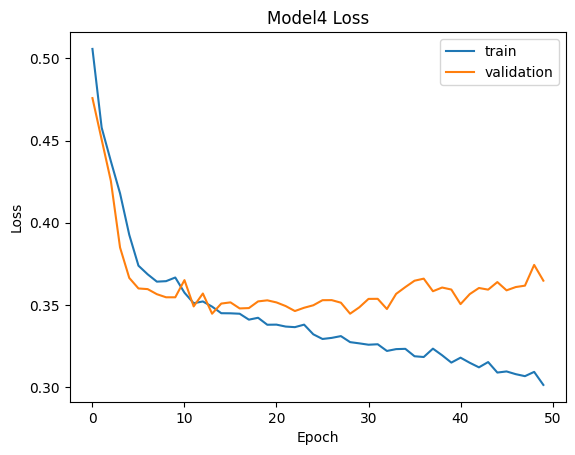

In [233]:
chart_loss(history4.history['loss'], history4.history['val_loss'], 'Model4 Loss')

63/63 [==============================] - 0s 2ms/step
Best Threshold = 0.18106679618358612, G-Measn=0.769


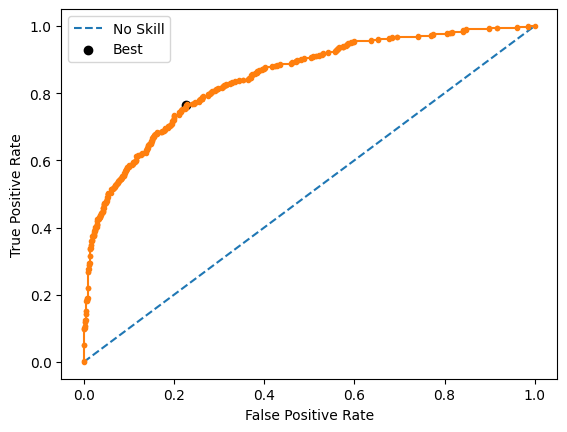

In [234]:
threshold4 = probabilities(model4, X_test, y_test)

In [235]:
# Predicting result using best as threshold
m4_y_pred_best = model4.predict(X_test)
m4_y_pred_best = (m4_y_pred_best > threshold4)

63/63 [==============================] - 0s 2ms/step


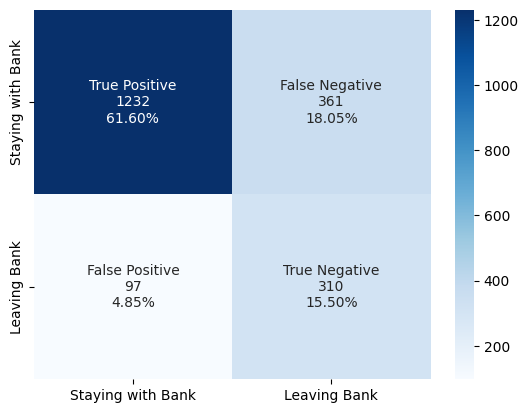

In [236]:
model_cm(y_test, m4_y_pred_best)

In [237]:
print(f"{metrics.classification_report(y_test, m4_y_pred_best)}")

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1593
           1       0.46      0.76      0.58       407

    accuracy                           0.77      2000
   macro avg       0.69      0.77      0.71      2000
weighted avg       0.83      0.77      0.79      2000



#### Observations
1. Accuracy fell futher to 77%
2. 458 incorrectly categorized customers is worse than the 348 of the Model1



---



## Model 5 RandomizedSearchCV

In [238]:
keras_estimator = KerasClassifier(build_fn=create_base_model, verbose=1)
param_random = {
    'batch_size': [32, 64, 128],
    'lr': [0.01, 0.1, 0.001],
}

kfold_splits = 3
random = RandomizedSearchCV(estimator=keras_estimator,
                            verbose=1,
                            cv=kfold_splits,
                            param_distributions=param_random, 
                            n_jobs=-1)

In [239]:
begin = time.time()

model5_result = random.fit(X_train, y_train, validation_split=0.2, verbose=2)

print(f"Best: {model5_result.best_score_} using {model5_result.best_params_}")
means = model5_result.cv_results_['mean_test_score']
stds = model5_result.cv_results_['std_test_score']
params = model5_result.cv_results_['params']

end = time.time()

print(f"Total Runtime of model 5 is {end - begin}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
200/200 - 3s - loss: 0.4930 - accuracy: 0.7944 - val_loss: 0.4918 - val_accuracy: 0.7906 - 3s/epoch - 13ms/step
Best: 0.7962485353151957 using {'lr': 0.01, 'batch_size': 32}
Total Runtime of model 5 is 56.34237790107727


In [240]:
estimator_v5 = create_base_model(batch_size=model5_result.best_params_['batch_size'],
                               lr=model5_result.best_params_['lr'])

estimator_v5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 256)               2816      
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 32)               

In [241]:
opt = tf.keras.optimizers.Adam(model5_result.best_params_['lr'])
estimator_v5.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [242]:
history5 = estimator_v5.fit(X_train, y_train, 
                      batch_size=model5_result.best_params_['batch_size'], 
                      epochs=50, 
                      verbose=2, 
                      validation_split = 0.2)

Epoch 1/50
200/200 - 3s - loss: 0.4836 - accuracy: 0.7967 - val_loss: 0.4471 - val_accuracy: 0.7906 - 3s/epoch - 13ms/step
Epoch 2/50
200/200 - 1s - loss: 0.4477 - accuracy: 0.8098 - val_loss: 0.4026 - val_accuracy: 0.8331 - 611ms/epoch - 3ms/step
Epoch 3/50
200/200 - 1s - loss: 0.4257 - accuracy: 0.8189 - val_loss: 0.3972 - val_accuracy: 0.8425 - 604ms/epoch - 3ms/step
Epoch 4/50
200/200 - 1s - loss: 0.4183 - accuracy: 0.8245 - val_loss: 0.3971 - val_accuracy: 0.8300 - 526ms/epoch - 3ms/step
Epoch 5/50
200/200 - 1s - loss: 0.3997 - accuracy: 0.8345 - val_loss: 0.3622 - val_accuracy: 0.8562 - 628ms/epoch - 3ms/step
Epoch 6/50
200/200 - 1s - loss: 0.3960 - accuracy: 0.8330 - val_loss: 0.3682 - val_accuracy: 0.8531 - 543ms/epoch - 3ms/step
Epoch 7/50
200/200 - 1s - loss: 0.3929 - accuracy: 0.8370 - val_loss: 0.3792 - val_accuracy: 0.8406 - 511ms/epoch - 3ms/step
Epoch 8/50
200/200 - 1s - loss: 0.3928 - accuracy: 0.8308 - val_loss: 0.3702 - val_accuracy: 0.8487 - 590ms/epoch - 3ms/step
Ep

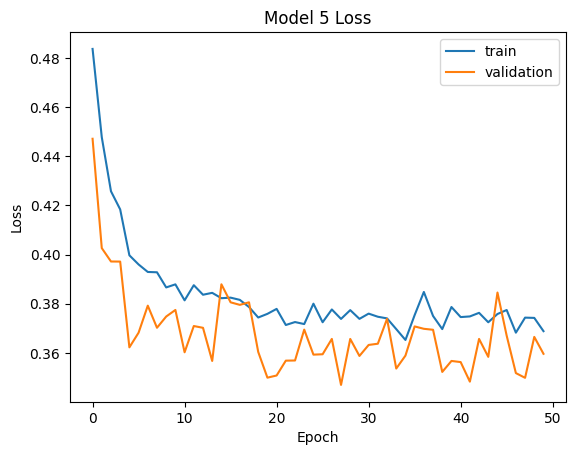

In [243]:
chart_loss(history5.history['loss'], history5.history['val_loss'], 'Model 5 Loss')

63/63 [==============================] - 0s 3ms/step
Best Threshold = 0.1455225646495819, G-Measn=0.758


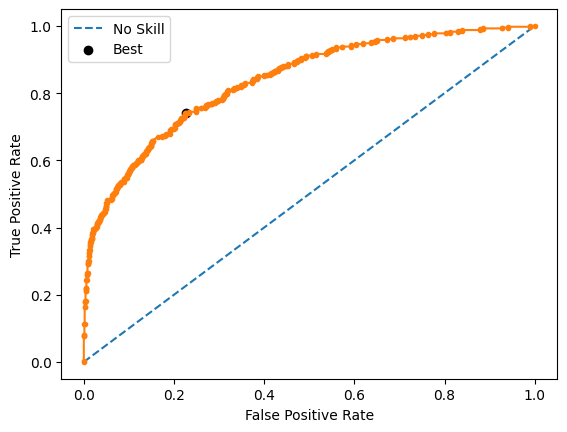

In [244]:
threshold5 = probabilities(estimator_v5, X_test, y_test)

In [245]:
# Predicting result using best as threshold
m5_y_pred_best = estimator_v5.predict(X_test)
m5_y_pred_best = (m5_y_pred_best > threshold5)

63/63 [==============================] - 0s 2ms/step


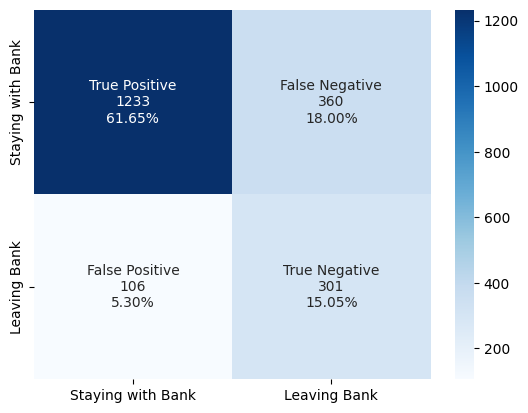

In [246]:
model_cm(y_test, m5_y_pred_best)

In [247]:
print(f"{metrics.classification_report(y_test, m5_y_pred_best)}")

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1593
           1       0.46      0.74      0.56       407

    accuracy                           0.77      2000
   macro avg       0.69      0.76      0.70      2000
weighted avg       0.83      0.77      0.78      2000



#### Observations
1. Accuracy stayed constant at 77% from model4
2. 466 incorrectly categorized customers is worse than model4 and a lot worse than the 348 of the Model1



---



## Model 6 GridSearch

In [248]:
keras_estimator = KerasClassifier(build_fn=create_base_model, verbose=1)
param_grid = {
    'batch_size': [64, 32, 128],
    'lr': [0.01, 0.1, 0.001],}

kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator,
                     verbose=1,
                     cv=kfold_splits,
                     param_grid=param_grid, 
                     n_jobs=-1)

In [249]:
begin = time.time()

model6_result = grid.fit(X_train, y_train, validation_split=0.2, verbose=2)

print(f"Best: {model6_result.best_score_} using {model6_result.best_params_}")
means = model6_result.cv_results_['mean_test_score']
stds = model6_result.cv_results_['std_test_score']
params = model6_result.cv_results_['params']

time.sleep(1)
end = time.time()

print(f"Total Runtime of model 6 is {end - begin}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
100/100 - 2s - loss: 0.4762 - accuracy: 0.7964 - val_loss: 0.4456 - val_accuracy: 0.7906 - 2s/epoch - 16ms/step
Best: 0.7962485353151957 using {'batch_size': 64, 'lr': 0.01}
Total Runtime of model 6 is 52.62102794647217


In [250]:
estimator_v6 = create_base_model(batch_size=model6_result.best_params_['batch_size'],
                               lr=model6_result.best_params_['lr'])

estimator_v6.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 256)               2816      
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_54 (Dense)            (None, 128)               32896     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 32)              

In [251]:
opt = tf.keras.optimizers.Adam(model6_result.best_params_['lr'])
estimator_v6.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [252]:
history6 = estimator_v6.fit(X_train, y_train, 
                      batch_size=model6_result.best_params_['batch_size'], 
                      epochs=50, 
                      verbose=2, 
                      validation_split = 0.2)

Epoch 1/50
100/100 - 2s - loss: 0.4824 - accuracy: 0.7978 - val_loss: 0.4425 - val_accuracy: 0.7987 - 2s/epoch - 18ms/step
Epoch 2/50
100/100 - 0s - loss: 0.4381 - accuracy: 0.8114 - val_loss: 0.4399 - val_accuracy: 0.7937 - 425ms/epoch - 4ms/step
Epoch 3/50
100/100 - 0s - loss: 0.4157 - accuracy: 0.8186 - val_loss: 0.3818 - val_accuracy: 0.8344 - 396ms/epoch - 4ms/step
Epoch 4/50
100/100 - 0s - loss: 0.3987 - accuracy: 0.8309 - val_loss: 0.4061 - val_accuracy: 0.8338 - 399ms/epoch - 4ms/step
Epoch 5/50
100/100 - 0s - loss: 0.3926 - accuracy: 0.8395 - val_loss: 0.3817 - val_accuracy: 0.8450 - 404ms/epoch - 4ms/step
Epoch 6/50
100/100 - 0s - loss: 0.3965 - accuracy: 0.8320 - val_loss: 0.3625 - val_accuracy: 0.8550 - 393ms/epoch - 4ms/step
Epoch 7/50
100/100 - 0s - loss: 0.3893 - accuracy: 0.8339 - val_loss: 0.3578 - val_accuracy: 0.8569 - 389ms/epoch - 4ms/step
Epoch 8/50
100/100 - 0s - loss: 0.3855 - accuracy: 0.8402 - val_loss: 0.3909 - val_accuracy: 0.8125 - 383ms/epoch - 4ms/step
Ep

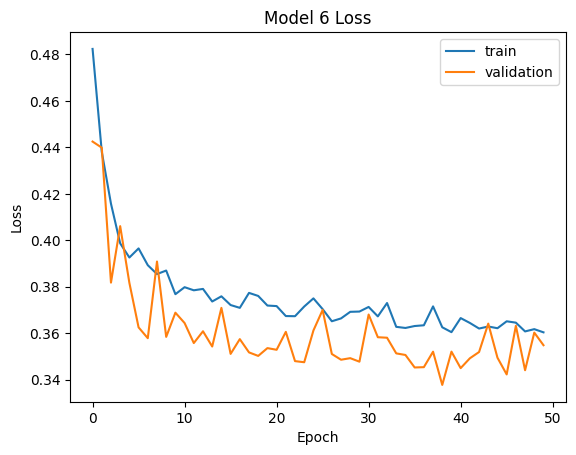

In [253]:
chart_loss(history6.history['loss'], history6.history['val_loss'], 'Model 6 Loss')

63/63 [==============================] - 0s 2ms/step
Best Threshold = 0.17371554672718048, G-Measn=0.765


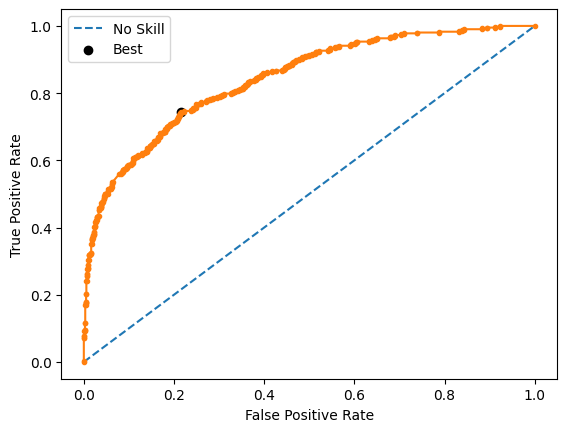

In [254]:
threshold6 = probabilities(estimator_v6, X_test, y_test)

In [255]:
# Predicting result using best as threshold
m6_y_pred_best = estimator_v6.predict(X_test)
m6_y_pred_best = (m6_y_pred_best > threshold6)

63/63 [==============================] - 0s 1ms/step


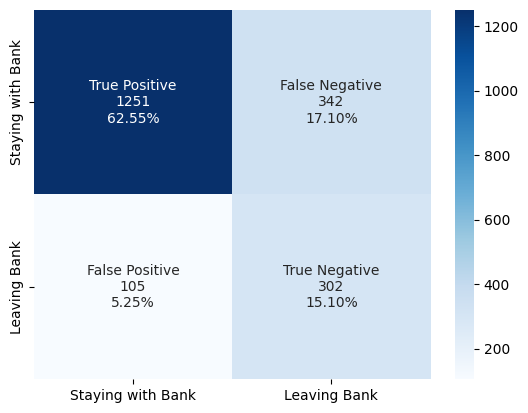

In [256]:
model_cm(y_test, m6_y_pred_best)

In [257]:
print(f"{metrics.classification_report(y_test, m6_y_pred_best)}")

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1593
           1       0.47      0.74      0.57       407

    accuracy                           0.78      2000
   macro avg       0.70      0.76      0.71      2000
weighted avg       0.83      0.78      0.79      2000



#### Observations
1. Accuracy increased to 78%
2. 447 incorrectly categorized customers is still worse than the 348 of the Model1



---



## Model 7 Dask with Keras Tuner



In [258]:
keras_estimator = KerasClassifier(build_fn=create_base_model, verbose=1)
dask_grid = {
    'batch_size': [64, 32, 128],
    'lr': [0.001, 0.01, 0.1],}

kfold_splits = 3
dask = DaskGridSearchCV(estimator=keras_estimator,
                     cv=kfold_splits,
                     param_grid=dask_grid, 
                     n_jobs=-1)

In [259]:
begin = time.time()

dask_result = dask.fit(X_train, y_train, validation_split=0.2, verbose=2)

print(f"Best: {dask_result.best_score_} using {dask_result.best_params_}")
means = dask_result.cv_results_['mean_test_score']
stds = dask_result.cv_results_['std_test_score']
params = dask_result.cv_results_['params']

time.sleep(1)
end = time.time()

print(f"Total Runtime of dask is {end - begin}")

67/67 - 4s - loss: 0.5229 - accuracy: 0.7775 - val_loss: 0.4897 - val_accuracy: 0.7948 - 4s/epoch - 59ms/step
67/67 - 4s - loss: 0.5106 - accuracy: 0.7876 - val_loss: 0.4776 - val_accuracy: 0.7948 - 4s/epoch - 58ms/step
42/42 [==============================] - 0s 5ms/step - loss: 0.4718 - accuracy: 0.8031
67/67 - 4s - loss: 0.5213 - accuracy: 0.7914 - val_loss: 0.4457 - val_accuracy: 0.8229 - 4s/epoch - 57ms/step
42/42 [==============================] - 0s 4ms/step - loss: 0.4978 - accuracy: 0.7847
67/67 - 3s - loss: 0.4969 - accuracy: 0.7893 - val_loss: 0.4702 - val_accuracy: 0.7948 - 3s/epoch - 51ms/step
42/42 [==============================] - 0s 5ms/step - loss: 0.4485 - accuracy: 0.8031
67/67 - 4s - loss: 0.4929 - accuracy: 0.7914 - val_loss: 0.4590 - val_accuracy: 0.7948 - 4s/epoch - 62ms/step
42/42 [==============================] - 0s 4ms/step - loss: 0.4457 - accuracy: 0.8009
67/67 - 5s - loss: 0.5002 - accuracy: 0.7884 - val_loss: 0.4178 - val_accuracy: 0.8229 - 5s/epoch - 68

In [260]:
tuner7 = RandomSearch(build_model, objective='val_accuracy', max_trials=5, executions_per_trial=3, project_name='Job_')

In [261]:
tuner7.search_space_summary()

Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_6

In [262]:
tuner7.search(X_train, y_train, epochs=5, validation_split=0.2)

In [263]:
tuner7.results_summary()

Results summary
Results in ./Job_
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
num_layers: 9
units_0: 64
units_1: 160
learning_rate: 0.001
units_2: 128
units_3: 256
units_4: 160
units_5: 32
units_6: 224
units_7: 64
units_8: 224
units_9: 160
Score: 0.8547916611035665

Trial 2 summary
Hyperparameters:
num_layers: 4
units_0: 32
units_1: 160
learning_rate: 0.01
units_2: 128
units_3: 192
units_4: 192
units_5: 96
units_6: 32
units_7: 96
units_8: 128
units_9: 96
Score: 0.8529166777928671

Trial 1 summary
Hyperparameters:
num_layers: 10
units_0: 96
units_1: 224
learning_rate: 0.001
units_2: 32
units_3: 192
units_4: 256
units_5: 64
units_6: 128
units_7: 160
units_8: 224
units_9: 192
Score: 0.850000003973643

Trial 0 summary
Hyperparameters:
num_layers: 10
units_0: 32
units_1: 64
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
Score: 0.8443750143051147

Trial 3 summary


### Model 7 - Using optimal settings from results summary

In [265]:
model7 = Sequential()
model7.add(Dense(64, activation='relu', kernel_initializer='he_uniform', input_dim = X_train.shape[1]))
model7.add(Dense(160, activation='relu', kernel_initializer='he_uniform'))
model7.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model7.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model7.add(Dense(160, activation='relu', kernel_initializer='he_uniform'))
model7.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model7.add(Dense(224, activation='relu', kernel_initializer='he_uniform'))
model7.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model7.add(Dense(224, activation='relu', kernel_initializer='he_uniform'))
model7.add(Dense(1, activation='sigmoid'))

model7.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 64)                704       
                                                                 
 dense_59 (Dense)            (None, 160)               10400     
                                                                 
 dense_60 (Dense)            (None, 128)               20608     
                                                                 
 dense_61 (Dense)            (None, 256)               33024     
                                                                 
 dense_62 (Dense)            (None, 160)               41120     
                                                                 
 dense_63 (Dense)            (None, 32)                5152      
                                                                 
 dense_64 (Dense)            (None, 224)             

In [266]:
opt = tf.keras.optimizers.Adam(0.001)
model7.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [267]:
begin = time.time()

history7 = model7.fit(X_train, y_train, 
                      batch_size=64, 
                      epochs=50, 
                      verbose=2, 
                      validation_split = 0.2)

time.sleep(1)
end = time.time()

print(f"Total Runtime of model 7 is {end - begin}")

Epoch 1/50
100/100 - 7s - loss: 0.4806 - accuracy: 0.7962 - val_loss: 0.4760 - val_accuracy: 0.8056 - 7s/epoch - 68ms/step
Epoch 2/50
100/100 - 1s - loss: 0.4470 - accuracy: 0.8034 - val_loss: 0.4440 - val_accuracy: 0.8131 - 1s/epoch - 11ms/step
Epoch 3/50
100/100 - 1s - loss: 0.4097 - accuracy: 0.8255 - val_loss: 0.4013 - val_accuracy: 0.8363 - 1s/epoch - 12ms/step
Epoch 4/50
100/100 - 1s - loss: 0.3782 - accuracy: 0.8434 - val_loss: 0.3785 - val_accuracy: 0.8512 - 1s/epoch - 11ms/step
Epoch 5/50
100/100 - 1s - loss: 0.3611 - accuracy: 0.8464 - val_loss: 0.3700 - val_accuracy: 0.8525 - 1s/epoch - 11ms/step
Epoch 6/50
100/100 - 1s - loss: 0.3556 - accuracy: 0.8495 - val_loss: 0.3720 - val_accuracy: 0.8462 - 1s/epoch - 11ms/step
Epoch 7/50
100/100 - 1s - loss: 0.3492 - accuracy: 0.8537 - val_loss: 0.3647 - val_accuracy: 0.8456 - 634ms/epoch - 6ms/step
Epoch 8/50
100/100 - 1s - loss: 0.3374 - accuracy: 0.8631 - val_loss: 0.3587 - val_accuracy: 0.8494 - 1s/epoch - 11ms/step
Epoch 9/50
100

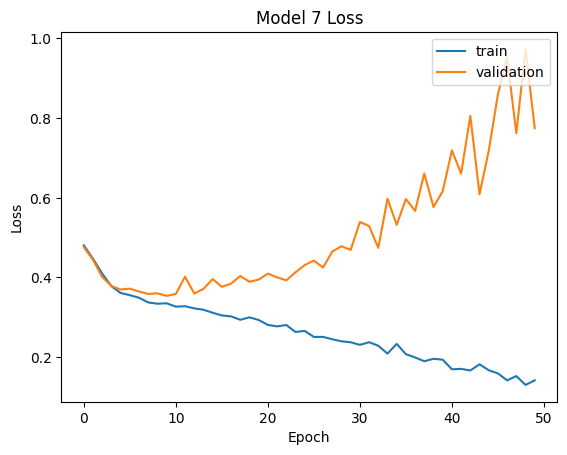

In [268]:
chart_loss(history7.history['loss'], history7.history['val_loss'], 'Model 7 Loss')

63/63 [==============================] - 0s 2ms/step
Best Threshold = 0.06452080607414246, G-Measn=0.721


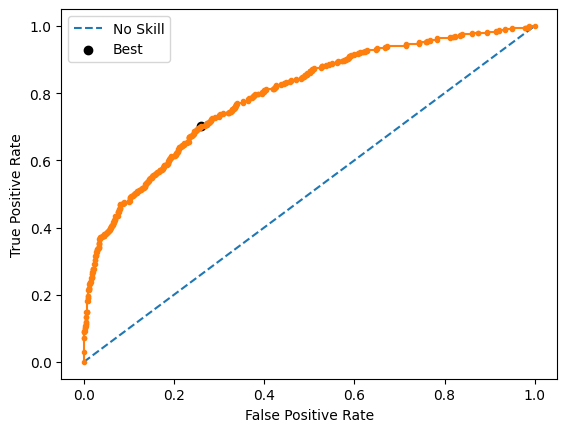

In [269]:
threshold7 = probabilities(model7, X_test, y_test)

In [270]:
# Predicting result using best as threshold
m7_y_pred_best = model7.predict(X_test)
m7_y_pred_best = (m7_y_pred_best > threshold7)

63/63 [==============================] - 0s 3ms/step


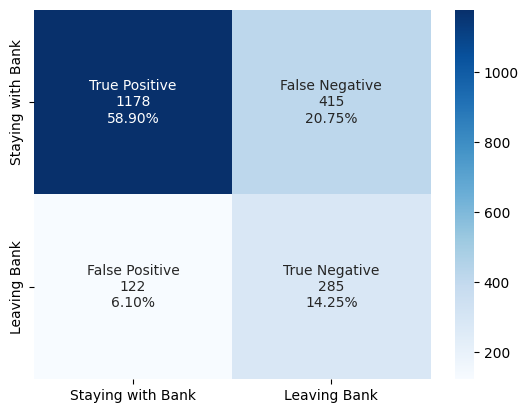

In [271]:
model_cm(y_test, m7_y_pred_best)

In [272]:
print(f"{metrics.classification_report(y_test, m7_y_pred_best)}")

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1593
           1       0.41      0.70      0.51       407

    accuracy                           0.73      2000
   macro avg       0.66      0.72      0.66      2000
weighted avg       0.80      0.73      0.75      2000



#### Observations
1. Accuracy increased to 73%
2. 537 incorrectly categorized customers is still worse than the 355 of the Model1



---



## Model 8 SMOTE + Keras Tuner

In [273]:
smote=SMOTE(sampling_strategy='not majority')
X_sm , y_sm = smote.fit_resample(X_train,y_train)

In [274]:
tuner8 = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 3,
    project_name='Job_Switch_')

In [275]:
tuner8.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_6 

In [276]:
tuner8.search(X_sm, y_sm, epochs=5, validation_split=0.2)

In [277]:
tuner8.results_summary()

Results summary
Results in ./Job_Switch_
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
num_layers: 4
units_0: 32
units_1: 64
learning_rate: 0.01
units_2: 160
units_3: 160
units_4: 192
units_5: 160
units_6: 128
Score: 0.7917320728302002

Trial 4 summary
Hyperparameters:
num_layers: 7
units_0: 96
units_1: 192
learning_rate: 0.0001
units_2: 160
units_3: 160
units_4: 128
units_5: 32
units_6: 128
Score: 0.7522239486376444

Trial 0 summary
Hyperparameters:
num_layers: 6
units_0: 224
units_1: 224
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
Score: 0.7510465780893961

Trial 2 summary
Hyperparameters:
num_layers: 7
units_0: 128
units_1: 64
learning_rate: 0.001
units_2: 192
units_3: 160
units_4: 128
units_5: 32
units_6: 32
Score: 0.7424123684565226

Trial 1 summary
Hyperparameters:
num_layers: 3
units_0: 160
units_1: 96
learning_rate: 0.0001
units_2: 128
units_3: 224
units_4: 96
units_5: 32
Score: 0.58437991142272

In [278]:
model8 = Sequential()
model8.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim = X_train.shape[1]))
model8.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model8.add(Dense(160, activation='relu', kernel_initializer='he_uniform'))
model8.add(Dense(160, activation='relu', kernel_initializer='he_uniform'))
#model8.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
#model8.add(Dense(160, activation='relu', kernel_initializer='he_uniform'))
#model8.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
#model8.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
#model8.add(Dense(192, activation='relu', kernel_initializer='he_uniform'))
#model8.add(Dense(160, activation='relu', kernel_initializer='he_uniform'))
model8.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(0.01)
model8.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model8.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 32)                352       
                                                                 
 dense_69 (Dense)            (None, 64)                2112      
                                                                 
 dense_70 (Dense)            (None, 160)               10400     
                                                                 
 dense_71 (Dense)            (None, 160)               25760     
                                                                 
 dense_72 (Dense)            (None, 1)                 161       
                                                                 
Total params: 38,785
Trainable params: 38,785
Non-trainable params: 0
_________________________________________________________________


In [279]:
history8 = model8.fit(X_sm, y_sm, 
                      batch_size=64, 
                      epochs=50, 
                      verbose=2, 
                      validation_split = 0.2)

Epoch 1/50
160/160 - 4s - loss: 0.5636 - accuracy: 0.7107 - val_loss: 0.7336 - val_accuracy: 0.4639 - 4s/epoch - 23ms/step
Epoch 2/50
160/160 - 1s - loss: 0.4714 - accuracy: 0.7703 - val_loss: 0.8382 - val_accuracy: 0.5812 - 531ms/epoch - 3ms/step
Epoch 3/50
160/160 - 1s - loss: 0.4570 - accuracy: 0.7831 - val_loss: 0.5229 - val_accuracy: 0.6986 - 524ms/epoch - 3ms/step
Epoch 4/50
160/160 - 1s - loss: 0.4376 - accuracy: 0.7950 - val_loss: 0.6069 - val_accuracy: 0.6621 - 517ms/epoch - 3ms/step
Epoch 5/50
160/160 - 1s - loss: 0.4280 - accuracy: 0.8002 - val_loss: 0.6105 - val_accuracy: 0.6554 - 606ms/epoch - 4ms/step
Epoch 6/50
160/160 - 1s - loss: 0.4268 - accuracy: 0.8018 - val_loss: 0.5837 - val_accuracy: 0.6664 - 799ms/epoch - 5ms/step
Epoch 7/50
160/160 - 1s - loss: 0.4204 - accuracy: 0.8047 - val_loss: 0.5237 - val_accuracy: 0.7241 - 1s/epoch - 7ms/step
Epoch 8/50
160/160 - 1s - loss: 0.4142 - accuracy: 0.8078 - val_loss: 0.6790 - val_accuracy: 0.6413 - 1s/epoch - 7ms/step
Epoch 9/

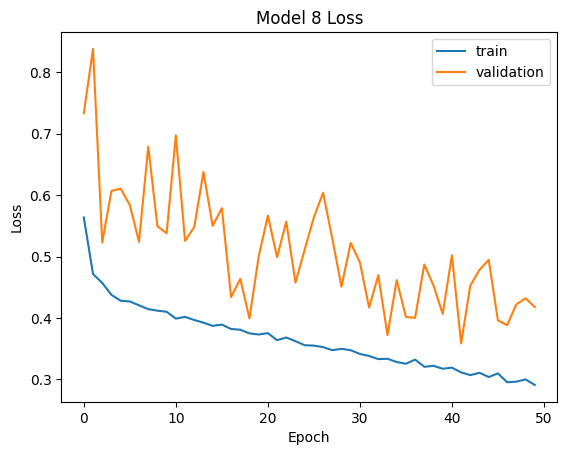

In [280]:
chart_loss(history8.history['loss'], history8.history['val_loss'], 'Model 8 Loss')

#### Observations
1. This model intoduced a significant amount of noise

399/399 [==============================] - 1s 3ms/step
Best Threshold = 0.3718961775302887, G-Measn=0.879


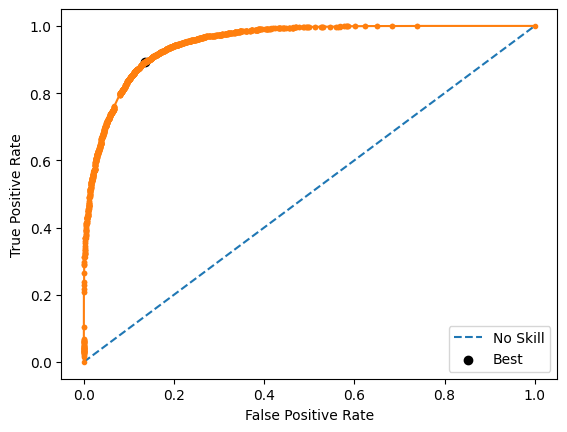

In [281]:
threshold8 = probabilities(model8, X_sm, y_sm)

In [282]:
# Predicting result using best as threshold
m8_y_pred_best = model8.predict(X_test)
m8_y_pred_best = (m8_y_pred_best > threshold8)

63/63 [==============================] - 0s 1ms/step


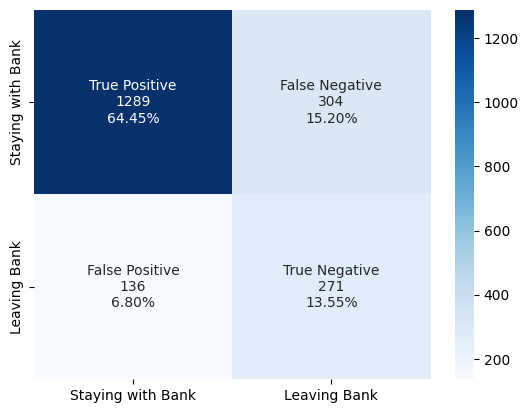

In [283]:
model_cm(y_test, m8_y_pred_best)

In [284]:
print(f"{metrics.classification_report(y_test, m8_y_pred_best)}")

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1593
           1       0.47      0.67      0.55       407

    accuracy                           0.78      2000
   macro avg       0.69      0.74      0.70      2000
weighted avg       0.82      0.78      0.79      2000



#### Observations
1. Accuracy increased to 78%
2. 440 incorrectly categorized customers is still worse than the 355 of the Model1



---



## Model 9 GridSearchCV with Keras

In [285]:
keras_estimator = KerasClassifier(build_fn=create_base_model, verbose = 1)
param_grid = {
    'batch_size': [64, 32, 128],
    'lr': [0.01, 0.1, 0.001],}

kfold_splits = 3
grid9 = GridSearchCV(estimator=keras_estimator,
                     verbose=1,
                     cv=kfold_splits,
                     param_grid=param_grid, 
                     n_jobs=-1)

In [286]:
begin = time.time()

model9_result = grid9.fit(X_train, y_train, validation_split=0.2, verbose=2)

print(f"Best: {model9_result.best_score_} using {model9_result.best_params_}")
means = model9_result.cv_results_['mean_test_score']
stds = model9_result.cv_results_['std_test_score']
params = model9_result.cv_results_['params']

time.sleep(1)
end = time.time()

print(f"Total Runtime of model 9 is {end - begin}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
100/100 - 2s - loss: 0.4866 - accuracy: 0.7927 - val_loss: 0.4540 - val_accuracy: 0.7906 - 2s/epoch - 16ms/step
Best: 0.7962485353151957 using {'batch_size': 64, 'lr': 0.01}
Total Runtime of model 9 is 80.85376024246216


In [287]:
estimator_v9 = create_base_model(batch_size=model9_result.best_params_['batch_size'],
                               lr=model9_result.best_params_['lr'])

estimator_v9.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 256)               2816      
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_81 (Dense)            (None, 32)              

In [288]:
opt = tf.keras.optimizers.Adam(model9_result.best_params_['lr'])
estimator_v9.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [289]:
history9 = estimator_v9.fit(X_sm, y_sm, 
                      batch_size = model9_result.best_params_['batch_size'], 
                      epochs=50, 
                      verbose=2, 
                      validation_split = 0.2)

Epoch 1/50
160/160 - 3s - loss: 0.5740 - accuracy: 0.7031 - val_loss: 0.8482 - val_accuracy: 0.4545 - 3s/epoch - 17ms/step
Epoch 2/50
160/160 - 1s - loss: 0.4998 - accuracy: 0.7513 - val_loss: 0.5697 - val_accuracy: 0.6056 - 991ms/epoch - 6ms/step
Epoch 3/50
160/160 - 1s - loss: 0.4900 - accuracy: 0.7634 - val_loss: 0.6301 - val_accuracy: 0.6421 - 1s/epoch - 6ms/step
Epoch 4/50
160/160 - 1s - loss: 0.4788 - accuracy: 0.7676 - val_loss: 0.6082 - val_accuracy: 0.6829 - 998ms/epoch - 6ms/step
Epoch 5/50
160/160 - 1s - loss: 0.4718 - accuracy: 0.7766 - val_loss: 0.5649 - val_accuracy: 0.7115 - 624ms/epoch - 4ms/step
Epoch 6/50
160/160 - 1s - loss: 0.4717 - accuracy: 0.7735 - val_loss: 0.6938 - val_accuracy: 0.5600 - 634ms/epoch - 4ms/step
Epoch 7/50
160/160 - 1s - loss: 0.4672 - accuracy: 0.7799 - val_loss: 0.7183 - val_accuracy: 0.6327 - 637ms/epoch - 4ms/step
Epoch 8/50
160/160 - 1s - loss: 0.4580 - accuracy: 0.7828 - val_loss: 0.5053 - val_accuracy: 0.7543 - 664ms/epoch - 4ms/step
Epoch

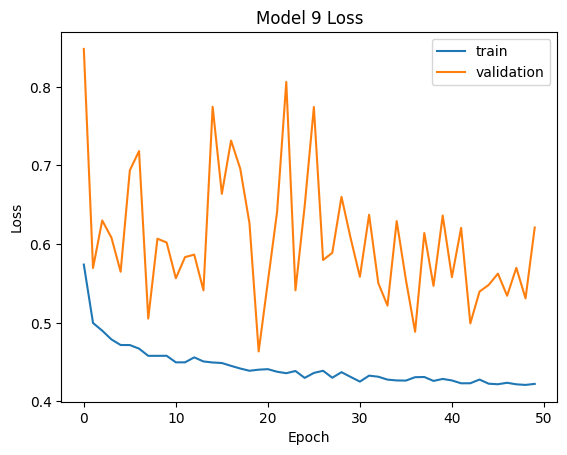

In [290]:
chart_loss(history9.history['loss'], history9.history['val_loss'], 'Model 9 Loss')

#### Observations
1. This model also has too much noise

63/63 [==============================] - 1s 5ms/step
Best Threshold = 0.32591092586517334, G-Measn=0.767


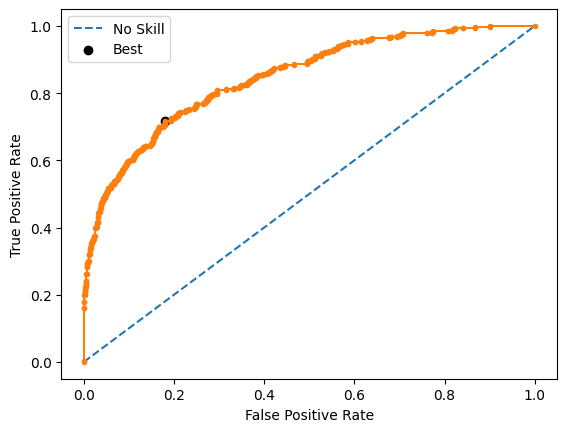

In [291]:
threshold9 = probabilities(estimator_v9, X_test, y_test)

In [292]:
# Predicting result using best as threshold
m9_y_pred_best = estimator_v9.predict(X_test)
m9_y_pred_best = (m9_y_pred_best > threshold9)

63/63 [==============================] - 0s 2ms/step


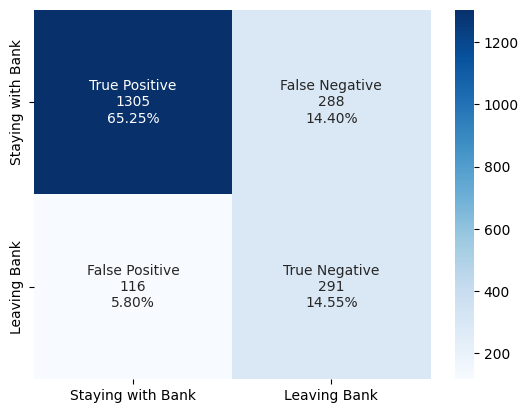

In [293]:
model_cm(y_test, m9_y_pred_best)

In [294]:
print(f"{metrics.classification_report(y_test, m9_y_pred_best)}")

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1593
           1       0.50      0.71      0.59       407

    accuracy                           0.80      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.83      0.80      0.81      2000



#### Observations
1. Accuracy increased to 80%
2. 404 incorrectly categorized customers is still worse than the 355 of the Model1



---



# Summary Clasification Report

In [295]:
print(f"\n\nModel 1\n{metrics.classification_report(y_test, m1_y_pred)}")
print("+"*65)
print(f"\n\nModel 2\n{metrics.classification_report(y_test, m2_y_pred_best)}")
print("+"*65)
print(f"\n\nModel 3\n{metrics.classification_report(y_test, m3_y_pred_best)}")
print("+"*65)
print(f"\n\nModel 4\n{metrics.classification_report(y_test, m4_y_pred_best)}")
print("+"*65)
print(f"\n\nModel 5\n{metrics.classification_report(y_test, m5_y_pred_best)}")
print("+"*65)
print(f"\n\nModel 6\n{metrics.classification_report(y_test, m6_y_pred_best)}")
print("+"*65)
print(f"\n\nModel 7\n{metrics.classification_report(y_test, m7_y_pred_best)}")
print("+"*65)
print(f"\n\nModel 8\n{metrics.classification_report(y_test, m8_y_pred_best)}")
print("+"*65)
print(f"\n\nModel 9\n{metrics.classification_report(y_test, m9_y_pred_best)}")




Model 1
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1593
           1       0.71      0.24      0.36       407

    accuracy                           0.83      2000
   macro avg       0.77      0.61      0.63      2000
weighted avg       0.81      0.83      0.79      2000

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


Model 2
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1593
           1       0.43      0.70      0.53       407

    accuracy                           0.75      2000
   macro avg       0.67      0.73      0.68      2000
weighted avg       0.81      0.75      0.77      2000

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


Model 3
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1593
           1       0.45      0.72      0.56       407

    accuracy        

In [296]:
end_total = time.time()
print(f"\n\nTotal Runtime for the entire Notebook is {end_total - begin_total}")



Total Runtime for the entire Notebook is 2657.9180221557617
